#### Calculate CO2 emissions for CMIP5

In [33]:
import numpy as np
import glob
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

co2file = '/work/mh0033/m300681/IPCC/processed_data/obs/Global_Carbon_Budget_2018v1.0.xlsx' # where observed data is stored
co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/' # where scenario data is stored, and there data is saved

# read in the historical co2 from the Global Carbon Budget
xls = pd.ExcelFile(co2file)
data = xls.parse(-1)
histyears = np.asarray(data['Unnamed: 0'])[14::]
fossil = np.asarray(data['Historical CO2 budget'][14::])
landuse = np.asarray(data['Unnamed: 2'])[14::]
fossil[~(fossil>0)] = 0
landuse[~(landuse>0)] = 0
histemis = (fossil+landuse)*3.66


co2 = {}
for scenario in ['rcp26','rcp45','rcp85']:
    data = np.genfromtxt(co2path+scenario.upper()+'_EMISSIONS.DAT',skip_header = 38,delimiter = ',')
    time = data[:,0]
    data = (data[:,1] + data[:,2])*3.66
    
    rcpyears = time[np.isin(time,np.arange(2018,2101))]
    rcpemis = data[np.isin(time,np.arange(2018,2101))]
    emis = np.concatenate([histemis[histyears<2018],rcpemis]).astype(float)
    years = np.concatenate([histyears[histyears<2018],rcpyears]).astype(float)

    cumul = np.nancumsum(emis)
   
    co2[scenario] = np.asarray([years,cumul]) 

co2['historical'] = np.asarray([histyears,np.nancumsum(histemis)]).astype(float)

with open(co2path+'CO2_CMIP5.npy', 'wb') as file:
    pickle.dump(co2,file)
    file.close()
    

#### Calculate CO2 emissions for CMIP6

In [35]:
import numpy as np
import glob
import os
from cdo import Cdo
import datetime
from netCDF4 import Dataset,num2date
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d
from itertools import cycle
import pandas as pd
from scipy.io import savemat,loadmat
import pickle

co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/' # where data is saved
co2file = '/work/mh0033/m300681/IPCC/processed_data/obs/Global_Carbon_Budget_2018v1.0.xlsx'

# co2 observations (global carbon budget 2018)
xls = pd.ExcelFile(co2file)
data = xls.parse(-1)
histyears = np.asarray(data['Unnamed: 0'][14::])
fossil = np.asarray(data['Historical CO2 budget'][14::])
landuse = np.asarray(data['Unnamed: 2'])[14::]
fossil[~(fossil>0)] = 0
landuse[~(landuse>0)] = 0
histemis = (fossil+landuse)*3.66

# ssp emissions from https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=welcome
sspyears = [2020,2030,2040,2050,2060,2070,2080,2090,2100]
ssp = {'ssp119': [39693.726,22847.271,10475.089,2050.362,-1525.978,-4476.970,-7308.783,-10565.023,-13889.788],
      'ssp245': [40647.530,43476.063,44252.900,43462.190,40196.485,35235.434,26838.373,16324.392,9682.859],
      'ssp126': [39804.013,34734.424,26509.183,17963.539,10527.979,4476.328,-3285.043,-8385.183,-8617.786],
      'ssp585': [43712.349,55296.583,68775.698,83298.220,100338.606,116805.249,129647.035,130576.239,126287.310]}

co2data = {}
for scenario in ['ssp119','ssp126','ssp245','ssp585']:
    data = np.concatenate([histemis,np.asarray(ssp[scenario])/1000]).astype(float)
    years = np.concatenate([histyears,sspyears]).astype(float)

    ## interpolate to yearly
    goodyears = np.arange(1750,2101)
    emis = interp1d(years,data)(goodyears)

    cumul = np.nancumsum(emis)
    co2data[scenario] = np.asarray([goodyears,cumul])

co2data['historical'] = np.asarray([histyears,np.nancumsum(histemis)]).astype(float)

with open(co2path+'CO2_CMIP6.npy','wb') as myFile:
    pickle.dump(co2data,myFile)
    myFile.close()


#### Download CMIP6 model data from ESGF 

In [5]:
import numpy as np
import glob
import os
from cdo import Cdo
import sys
import pickle
from cmip6_download import cmip6_download

modellist = ['EC-Earth3','EC-Earth3-Veg','MIROC-ES2L','NorCPM1','NorESM2-LM','GFDL-ESM4','E3SM-1-0','FGOALS-g3','FGOALS-f3-L'] # NESM3

modellist = ['CESM2-FV2']
variables = ['siarean','sivoln','siareas','sivols','siconc','sivol']

scenarios = ['historical','ssp119','ssp126','ssp245','ssp585','piControl']
#scenarios = ['historical']
for model in modellist:
    print(model)
    for scenario in scenarios:
        print(scenario)
        if scenario == 'piControl':
            varis = variables#['siareas','siarean']
        else:
            varis = variables
        for var in varis:
            cmip6_download(var,'mon',scenario,model)

print('DONE!')

ModuleNotFoundError: No module named 'cmip6_download'

#### Process data from ESGF

In [1]:
import numpy as np
import glob
import os
from cdo import Cdo
import sys
import pickle
from cmip6_download import cmip6_download

cdo = Cdo()
hemisphere = 'sh'
if hemisphere == 'nh':
    lonlatbox = '0,360,0,90'
else:
    lonlatbox = '0,360,-90,0'
inpath = '/work/mh0033/m300681/IPCC/processed_data/CMIP6/external/download/'
outpath = '/work/mh0033/m300681/IPCC/processed_data/CMIP6/'

folders = [os.path.basename(x) for x in glob.glob(inpath+'*')]
print(folders)

# one folder is for one model and one variable, and thus contains
# several members of the model
for folder in folders:
    print(folder)
    files = [os.path.basename(x) for x in glob.glob(inpath+folder+'/*.nc')]
    # use first file to pull information
    variable = files[0].split('_')[0]
    scenario = files[0].split('_')[3]
    model = files[0].split('_')[2]
    realm = files[0].split('_')[1]
    gridtype = files[0].split('_')[5]
    print(model, variable, scenario)
    # figure out the members present
    members = list(set([file.split('_')[4] for file in files]))
    print(members)
    for member in members:
        try:
            name = variable+'_'+realm+'_'+model+'_'+scenario+'_'+member+'_'+gridtype+'_'
            if variable == 'tas':
                #gmst
                outputfile = outpath+'gmst/gmst_'+model+'_'+member+'_'+scenario+'.nc'
                if not os.path.isfile(outputfile):
                    cdo.fldmean(input='-chname,tas,gmst -selvar,tas -yearmean -mergetime '+inpath+folder+'/'+name+'*.nc',
                           output = outputfile)
                #gmst monthly
                outputfile = outpath+'gmst_monthly/gmst_monthly_'+model+'_'+member+'_'+scenario+'.nc'
                if not os.path.isfile(outputfile):
                    cdo.fldmean(input='-chname,tas,gmst_monthly -selvar,tas -monmean -mergetime '+inpath+folder+'/'+name+'*.nc',
                           output = outputfile)
                # gmst arctic
                outputfile = outpath+'gmst_arctic/gmst_arctic_'+model+'_'+member+'_'+scenario+'.nc'
                if not os.path.isfile(outputfile):
                    cdo.fldmean(input='-chname,tas,gmst_arctic -sellonlatbox,0,360,66,90 -selvar,tas -monmean -mergetime '+inpath+folder+'/'+name+'*.nc',
                           output = outputfile)
                    
            elif variable == 'siconc':
                outputfile = outpath+'sia_'+hemisphere+'/sia_'+hemisphere+'_'+model+'_'+member+'_'+scenario+'.nc'
                inputfile = inpath+folder+'/'+name+'*.nc'
                if not os.path.isfile(outputfile):
                    gridfile = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'.nc'
                    if not os.path.isfile(gridfile):
                        cdo.gridarea(input = '-sellonlatbox,'+lonlatbox+' -selvar,siconc -mergetime '+inpath+folder+'/'+name+'*.nc',
                                output = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'_calc.nc')
                        gridfile = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'_calc.nc'
                    # SIA
                    cdo.fldsum(input = '-chname,siconc,sia -divc,1e14 -mul '+gridfile+' -sellonlatbox,'+lonlatbox+' -setmissval,0 -selname,siconc -mergetime '+inputfile,
                                               output = outputfile)
                    # SIE
                    outputfile = outpath+'sie_'+hemisphere+'/sie_'+hemisphere+'_'+model+'_'+member+'_'+scenario+'.nc'
                    cdo.fldsum(input = '-chname,siconc,sie -divc,1e14 -mul '+gridfile+' -setrtoc2,15,100,100,0 -sellonlatbox,'+lonlatbox+' -setmissval,0 -selname,siconc -mergetime '+inputfile,
                                               output = outputfile)
                    
                # calculate mean concentration over 2 periods
                if scenario in ['ssp126','ssp245','ssp585']:
                    # second part of first period
                    outputfile = outpath+'conc_'+hemisphere+'/conc_'+hemisphere+'_2015-2018_'+model+'_'+member+'_'+scenario+'.nc'
                    if not os.path.isfile(outputfile):
                        cdo.remapnn(outpath+'conc_grid_'+hemisphere+'.nc',
                                    input='-ymonmean -selyear,2015/2018 -selname,siconc -mergetime '+inputfile,
                                    output = outputfile)
                    # second period
                    outputfile = outpath+'conc_'+hemisphere+'/conc_'+hemisphere+'_2045-2054_'+model+'_'+member+'_'+scenario+'.nc'
                    if not os.path.isfile(outputfile):
                        cdo.remapnn(outpath+'conc_grid_'+hemisphere+'.nc',
                                input='-ymonmean -selyear,2045/2054 -selname,siconc -mergetime '+inputfile,
                                output = outputfile)
                elif scenario == 'historical':
                    # first part of first period
                    outputfile = outpath+'conc_'+hemisphere+'/conc_'+hemisphere+'_2009-2014_'+model+'_'+member+'_'+scenario+'.nc'
                    if not os.path.isfile(outputfile):
                        cdo.remapnn(outpath+'conc_grid_'+hemisphere+'.nc',
                                input='-ymonmean -selyear,2009/2014 -selname,siconc -mergetime '+inputfile,
                                output = outputfile)
                        
            elif variable == 'sivol':
                outputfile = outpath+'siv_'+hemisphere+'/siv_'+hemisphere+'_'+model+'_'+member+'_'+scenario+'.nc'
                inputfile = inpath+folder+'/'+name+'*.nc'
                if not os.path.isfile(outputfile):
                    gridfile = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'.nc'
                    if not os.path.isfile(gridfile):
                        cdo.gridarea(input = '-sellonlatbox,'+lonlatbox+' -selvar,sivol -mergetime '+inpath+folder+'/'+name+'*.nc',
                                output = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'_calc.nc')
                        gridfile = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'_calc.nc'
                    cdo.fldsum(input = '-chname,sivol,siv -divc,1e12 -mul '+gridfile+' -sellonlatbox,'+lonlatbox+' -selname,sivol -mergetime '+inputfile,
                                   output = outputfile)
            elif variable == 'sithick':
                outputfile = outpath+'siv_'+hemisphere+'/siv_'+hemisphere+'_'+model+'_'+member+'_'+scenario+'.nc'
                name_conc = name.replace('sithick','siconc')
                folder_conc = folder.replace('sithick','siconc')
                inputfile = inpath+folder+'/'+name+'*.nc'
                conc_input = '-divc,100 -mergetime '+inpath+folder_conc+'/'+name_conc+'*.nc'
        
                if not os.path.isfile(outputfile):
                    gridfile = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'.nc'
                    if not os.path.isfile(gridfile):
                        cdo.gridarea(input = '-sellonlatbox,'+lonlatbox+' -selvar,sithick -mergetime '+inpath+folder+'/'+name+'*.nc',
                                output = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'_calc.nc')
                        gridfile = outpath+'gridareas/'+model+'_gridarea_'+hemisphere+'_calc.nc'
                    cdo.selname('sithick',input='-mergetime '+inputfile,output='temp_thk.nc')
                    try:
                        cdo.selname('siconc',input=conc_input,output='temp_conc.nc')
                    except:
                        print('No concentration data!')
                        continue
                    cdo.fldsum(input = '-monmean -chname,sithick,siv -divc,1e12 -mul '+gridfile+' -sellonlatbox,'+lonlatbox+' -mul temp_thk.nc temp_conc.nc',
                                output=outputfile)
                    os.remove('temp_conc.nc')
                    os.remove('temp_thk.nc')
            elif variable == 'siarea'+hemisphere[0]:
                outputfile = outpath+'sia_'+hemisphere+'/sia_'+hemisphere+'_'+model+'_'+member+'_'+scenario+'.nc'
                if not os.path.isfile(outputfile):
                    cdo.monmean(input='-chname,siarea'+hemisphere[0]+',sia -mergetime '+inpath+folder+'/'+name+'*.nc',output=outputfile)
            elif variable == 'sivol'+hemisphere[0]:
                outputfile = outpath+'siv_'+hemisphere+'/siv_'+hemisphere+'_'+model+'_'+member+'_'+scenario+'.nc'
                if not os.path.isfile(outputfile):
                    cdo.monmean(input='-chname,sivol'+hemisphere[0]+',siv -mergetime '+inpath+folder+'/'+name+'*.nc',output=outputfile)
        except Exception as e:
            print(e)
            print('*************** ERROR ***************')
            print(model, variable, scenario, member)
            print('*************************************')
            
print('DONE!')

-->> Could not load xarray!! <<--
['sivol_mon_ssp245_GFDL-ESM4', 'siarean_mon_historical_NorESM2-LM', 'tas_mon_ssp245_BCC-CSM2-MR', 'sithick_mon_ssp585_GFDL-ESM4', 'siconc_mon_ssp245_GFDL-ESM4', 'sivols_mon_historical_CNRM-CM6-1-HR', 'sithick_mon_ssp119_GFDL-ESM4', 'siconc_mon_piControl_MIROC-ES2L', 'siconc_mon_historical_MIROC-ES2L', 'sivol_mon_ssp126_GFDL-ESM4', 'sithick_mon_historical_NorCPM1', 'sivol_mon_ssp585_BCC-CSM2-MR', 'siconc_mon_historical_NESM3', 'tas_mon_ssp245_EC-Earth3', 'tas_mon_historical_NorCPM1', 'tas_mon_ssp119_MIROC-ES2L', 'sivol_mon_historical_GFDL-ESM4', 'siarean_mon_ssp585_IPSL-CM6A-LR', 'areacello_fx_1pctCO2_BCC-ESM1', 'siarean_mon_ssp119_IPSL-CM6A-LR', 'siarean_mon_ssp245_IPSL-CM6A-LR', 'siconc_mon_ssp585_MIROC-ES2L', 'tas_mon_ssp119_EC-Earth3-Veg', 'sivol_mon_ssp585_GFDL-ESM4', 'siconc_mon_ssp119_EC-Earth3-Veg', 'tas_mon_ssp245_GFDL-ESM4', 'siareas_mon_piControl_NorESM2-LM', 'sithick_mon_ssp245_NESM3', 'sivoln_mon_piControl_CNRM-CM6-1-HR', 'siconc_mon_histor

Read in data from all nc files and put into mat format

In [9]:
# This script reads data from the nc files of every simulation and every variable
# and writes it to a .mat file, for every scenario separately
# The script works with CMIP5 and CMIP6 data
# Author: Jakob Doerr (jakob.doerr@mpimet.mpg.de)
# Date: 25.09.2019
import numpy as np
import glob
import os
import datetime
from netCDF4 import Dataset,num2date
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import cycle
from scipy.io import savemat,loadmat
from dateutil.relativedelta import *
from IPython.display import display,clear_output
import multiprocessing as mp
from functools import partial
%matplotlib inline

# ------------- Define functions -------------------------------------------------------------
# this function reads an nc file and extracts data 
def read_in(filename,month,var):
    file = Dataset(filename)
    try:
        time = np.squeeze(num2date(file.variables['time'][:].copy(),file.variables["time"].units,calendar = file.variables["time"].calendar))
    except Exception as e:
        #print(e)
        time = np.squeeze(file.variables['time'][:].copy())
        time = [datetime.datetime(years[scenario][0],1,1)+relativedelta(months=+val) for val in time]

    data = np.squeeze(file.variables[var][:].copy())
    if 'HadGEM2-ES' in filename or 'HadGEM2-CC' in filename: # some cmip5 models...
        time = time[1::]
        data = data[1::]
    raw_years = np.asarray([time[i].year for i in range(len(time))])
    if month >= 0:
        model_months = np.asarray([time[i].month for i in range(len(time))])
        raw_years = raw_years[np.where(model_months==month+1)]
        data = data[np.where(model_months==month+1)]
        #time_hist = time_hist[month::12]
        #data_hist = data_hist[month::12]
    return raw_years,data

# this function reads the data and sorts it by month (if necessary) and sets NaNs where data is missing
# if the scenario is SSP XXX, the function will still try to read historical data, and the final npy
# file of the scenario will still contain historical data. This makes it easier to look at long timeseries of
# historical and future scenarios, as they are then already matched.
def get_variable(month=-1,filename='',var='',scenario=''):
    try:
        try:
            time_hist,data_hist = read_in(filename+'_historical.nc',month,var)
        except Exception as e: # no data for historical? -> fill with nans
            #print(e)
            #print(filename)
            time_hist = years['historical']
            data_hist = np.zeros(len(years['historical'])) * np.nan
        if scenario != 'historical': # concatenate historical and ssp (rcp)
            time_future,data_future = read_in(filename+'_'+scenario+'.nc',month,var)
            # avoid double times (yes, some models have that...)
            data_hist = [data_hist[i] for i in range(len(data_hist)) if time_hist[i] < time_future[0]]
            time_hist = [time_hist[i] for i in range(len(time_hist)) if time_hist[i] < time_future[0]]

            time = np.concatenate([time_hist,time_future])
            data = np.concatenate([data_hist,data_future])
        else: # only historical
            time = time_hist
            data = data_hist

        new_time = years[scenario]
        out_data = np.zeros(len(new_time))*np.nan
        out_data[np.isin(new_time,time)] = data[np.isin(time,new_time)]

        # some special cases...
        if var in ['sia','sie'] and np.nanmean(out_data) > 1000:
            print(filename)
            out_data /= 1e12
        # correct models with wrong units in volume 
        if var in ['siv']:
            order = np.floor(np.log10(np.nanmean(out_data)))
            if order > 9:
                out_data/= 1e12
            elif order > 2:
                out_data/= 1e3
        if len(data.shape)> 1:
            raise ValueError('Data array too big!')

    except Exception as e:
        out_data = np.zeros(len(years[scenario]))*np.nan
    return out_data

# ---------------- Start ------------------------------------------------------

for cmipname in ['CMIP5','CMIP6']:
    if cmipname == 'CMIP6':
        scenarios = ['historical','ssp119','ssp126','ssp245','ssp585']
        histend = 2014
    else:
        scenarios = ['historical','rcp26','rcp45','rcp85']
        histend = 2005


    years = {'historical':np.arange(1850,histend+1),'ssp119':np.arange(1850,2100),'ssp126':np.arange(1850,2100),
             'ssp245':np.arange(1850,2100),'ssp585':np.arange(1850,2100),'rcp26':np.arange(1850,2100),
            'rcp85':np.arange(1850,2100),'rcp45':np.arange(1850,2100),'1pctCO2':np.arange(1850,2000)}

    basepath = '/work/mh0033/m300681/IPCC/processed_data/'+cmipname+'/'
    hemisphere = 'nh'

    

    # before we start, create a list of all files for the three variables sia, siv, gmst
    # and save it to txt files
    for var in ['gmst','sia_'+hemisphere,'siv_'+hemisphere]:
        files_list = list(sorted([os.path.basename(x) for x in glob.glob(basepath+var+'/'+var+'_*.nc')]))
        with open('/home/mpim/m300681/SIMIP/'+var+'_'+cmipname+'_files.txt', 'w') as f:
            for item in files_list:
                f.write("%s\n" % item)
            f.close()
    # --------------------------------------------------------------------------
    # start
    for scenario in scenarios:

        print('************************'+ scenario+ '******************************')
        len_years = len(years[scenario])

        # create list of available models that have GMST or SIA
        models = {}
        models['sia'] = list(sorted(set([os.path.basename(x).split('_')[2] 
                                      for x in glob.glob(basepath+'sia_'+hemisphere+'/'+'sia_'+hemisphere+'_*_'+scenario+'.nc')])))
        models['gmst'] = list(sorted(set([os.path.basename(x).split('_')[1] 
                                      for x in glob.glob(basepath+'gmst/gmst_*_'+scenario+'.nc')])))
        models['siv'] = list(sorted(set([os.path.basename(x).split('_')[2] 
                                      for x in glob.glob(basepath+'siv_'+hemisphere+'/'+'siv_'+hemisphere+'_*_'+scenario+'.nc')])))

        modellist = list(set(np.concatenate([models['sia'],models['gmst'],models['siv']])))
        modellist = list(sorted(set(modellist)))

        print(modellist)
        # construct a list of simulations for every model in the file
        # I will just fill the simulations of the other variables with NaNs if they don't have any 
        # data
        simulations = []
        for model in modellist:
            all_members = []
            for var in ['gmst','sia_'+hemisphere,'siv_'+hemisphere]:
                members = [os.path.basename(x) for x in glob.glob(basepath+var+'/'+var+'_'+model+'_*_'+scenario+'.nc')]
                members  = [members[i][len(model)+len(var)+2:-(len(scenario)+4)] for i in range(len(members))]
                for member in members:
                    all_members.append(member)
            ensemblemembers = list(sorted(set(all_members),key = lambda x: int(x[1:3].replace('i',''))))
            for member in ensemblemembers:
                simulations.append(model+'_'+member)

        print(simulations)
        print(len(simulations))

        data_array = {}
        ### GMST ###### 
        # Separate because it's the only one where we only need annual mean
        print('GMST')
        var = 'gmst'
        data_array['gmst'] = np.zeros((len(simulations),len_years))
        for i,simulation in enumerate(simulations):
            filename = basepath+var+'/'+var+'_'+simulation
            try:
                data = get_variable(-1,filename,var,scenario)
            except Exception as e:
                #print(e)
                #print(simulation)
                data = np.zeros(len_years)*np.nan
            data_array['gmst'][i,:] = data

        ### SIA, SIV #####
        pool = mp.Pool(processes=12) # parallel calculation
        for var in ['sia','siv']:
            print(var)
            data_array[var+'_'+hemisphere] = np.zeros((len(simulations),len_years,12))
            count = 0
            for i,simulation in enumerate(simulations):
                # print percentage

                print('\r',str(np.round(100*count/(len(simulations)),1))+'%',end='')
                filename = basepath+var+'_'+hemisphere+'/'+var+'_'+hemisphere+'_'+simulation

                data = pool.map(partial(get_variable,filename=filename,
                                var=var,scenario=scenario),range(12))

                data = np.asarray(data)
                data = np.swapaxes(data,0,1)
                # more special cases...
                if var == 'siv': # remove high sea-ice volume models
                    data[data > 70] = np.nan
                    if hemisphere == 'nh' and cmipname == 'CMIP5' and 'GISS' in simulation:
                        data *= np.nan

                data_array[var+'_'+hemisphere][i,:,:] = data
                count += 1
            print()       
        pool.close()
        pool.join()
        print('Pool joined.')
        # save to mat file
        data_array['Simulation_names'] = simulations
        data_array['Years'] = years[scenario]
        savemat(cmipname+'_'+scenario+'_'+hemisphere+'.mat',data_array)

        # additionally, save the individual modellists (for every variable) to files
        # do this only for the NH, because that is what we look at in the paper
        if hemisphere == 'nh':
            for variable in ['sia','gmst','siv']:
                if variable == 'gmst':
                    var = variable
                else:
                    var = variable+'_nh'
                f = open('/home/mpim/m300681/IPCC/CMIP6_models/'+scenario+'_'+variable+'_available_models.txt','w')
                f.write('Model,N_ens\n')
                for model in models[variable]:
                    n_ens = len([os.path.basename(x) for x in glob.glob(basepath+var+'/'+var+'_'+model+'_*_'+scenario+'.nc')])
                    f.write(model+','+str(n_ens)+'\n')
                f.close()
    print('DONE')

************************historical******************************
['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CESM1-CAM5-1-FV2', 'CESM1-FASTCHEM', 'CESM1-WACCM', 'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CNRM-CM5-2', 'CSIRO-Mk3-6-0', 'CanCM4', 'CanESM2', 'EC-EARTH', 'FGOALS-g2', 'FGOALS-s2', 'FIO-ESM', 'GFDL-CM2p1', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadCM3', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC4h', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m', 'fio-esm', 'inmcm4']
['ACCESS1-0_r1i1p1', 'ACCESS1-0_r2i1p1', 'ACCESS1-0_r3i1p1', 'ACCESS1-3_r1i1p1', 'ACCESS1-3_r2i1p1', 'ACCESS1-3_r3i1p1', 'BNU-ESM_r1i1p1', 'CCSM4_r1i1p1', 'CCSM4_r2i1p1', 'CCSM4_r3i1p1', 'CCSM4_r4i1p1', 'CCSM4_r5i1p1', 'CCSM4_r6i1p1', 'CESM1-BGC_r1i1p

/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-

 99.5%
siv
 15.4%

/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in greater


 44.1%

/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-

 99.5%
Pool joined.
************************rcp26******************************
['BNU-ESM', 'CCSM4', 'CESM1-CAM5', 'CESM1-WACCM', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'EC-EARTH', 'FGOALS-g2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m', 'fio-esm']
['BNU-ESM_r1i1p1', 'CCSM4_r1i1p1', 'CCSM4_r2i1p1', 'CCSM4_r3i1p1', 'CCSM4_r4i1p1', 'CCSM4_r5i1p1', 'CCSM4_r6i1p1', 'CESM1-CAM5_r1i1p1', 'CESM1-CAM5_r2i1p1', 'CESM1-CAM5_r3i1p1', 'CESM1-WACCM_r2i1p1', 'CESM1-WACCM_r3i1p1', 'CESM1-WACCM_r4i1p1', 'CNRM-CM5_r1i1p1', 'CSIRO-Mk3-6-0_r1i1p1', 'CSIRO-Mk3-6-0_r2i1p1', 'CSIRO-Mk3-6-0_r3i1p1', 'CSIRO-Mk3-6-0_r4i1p1', 'CSIRO-Mk3-6-0_r5i1p1', 'CSIRO-Mk3-6-0_r6i1p1', 'CSIRO-Mk3-6-0_r7i1p1', 'CSIRO-Mk3-6-0_r8i1p1', 'CSIRO-Mk3-6-0_r9i1p1', 'CSIRO-Mk3-6-0_r10i1p1', 'CanESM2_r1i1p

/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-

 99.7%
siv
 5.8%

/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-

 99.7%
Pool joined.
************************ssp119******************************
['CAMS-CSM1-0', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MRI-ESM2-0', 'UKESM1-0-LL']
['CAMS-CSM1-0_r1i1p1f1', 'CAMS-CSM1-0_r2i1p1f1', 'CNRM-ESM2-1_r1i1p1f2', 'CNRM-ESM2-1_r2i1p1f2', 'CNRM-ESM2-1_r3i1p1f2', 'CNRM-ESM2-1_r4i1p1f2', 'CNRM-ESM2-1_r5i1p1f2', 'CanESM5_r1i1p1f1', 'CanESM5_r2i1p1f1', 'CanESM5_r3i1p1f1', 'CanESM5_r4i1p1f1', 'CanESM5_r5i1p1f1', 'CanESM5_r6i1p1f1', 'CanESM5_r7i1p1f1', 'CanESM5_r8i1p1f1', 'CanESM5_r9i1p1f1', 'CanESM5_r10i1p1f1', 'CanESM5_r11i1p1f1', 'CanESM5_r12i1p1f1', 'CanESM5_r13i1p1f1', 'CanESM5_r14i1p1f1', 'CanESM5_r15i1p1f1', 'CanESM5_r16i1p1f1', 'CanESM5_r17i1p1f1', 'CanESM5_r18i1p1f1', 'CanESM5_r19i1p1f1', 'CanESM5_r20i1p1f1', 'CanESM5_r21i1p1f1', 'CanESM5_r22i1p1f1', 'CanESM5_r23i1p1f1', 'CanESM5_r24i1p1f1', 'CanESM5_r25i1p1f1', 'EC-Earth3_r4i1p1f1', 'EC-Earth3-Veg_r1i1p1f1', 'EC-Earth3-Veg_r2i1p1f1', 'EC-Ea

Calculate sensitivities for Observations

In [10]:
# this script calculates sensitivity metrics, as well as other metrics such as
# the mean sea-ice area and volume over a control period. The calculated metrics are:
# sia vs co2; sia vs gmst; gmst vs co2; mean sept. and march sia over a control period;
# mean sept. and march siv over a control period; variability of the sept. sia in the
# piControl run.
# For SIV and the variability of the piControl run, there is no data for the observations, hence
# these metrics are set to NaN here.
# Author: Jakob Doerr (jakob.doerr@mpimet.mpg.de)
# Date: 25.09.2019

import numpy as np
from netCDF4 import Dataset,num2date
import scipy.stats as stats
import pickle

hemisphere = 'nh'
co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/'
obspath = '/work/mh0033/m300681/IPCC/processed_data/obs/'
analysis_period = np.arange(1979,2015) 
control_period = np.arange(1979,1999) # control period within the analysis period
last_period = np.arange(2005,2015) # last period
# ----------------------------------------------------------
# observations of sia 
sia_names = ['nsidc_nt','nsidc_bt','osisaf']
data = np.load(obspath+'SIA_observations_'+hemisphere+'.npy',allow_pickle=True)
obs_sia = {}
for obs_name in sia_names:
    obs_sia[obs_name] = {}
    obs_data = data[obs_name]
    obs_time = data['years']
    for month in np.arange(1,13):
        obs_sia[obs_name][month] = obs_data["{:02d}".format(month)][np.isin(obs_time,analysis_period)]

# ----------------------------------------------------------
# observations of GMST
gmst_names = ['noaa','gistemp','HadCRUT','berkeley']
obs_gmst = {}
for obs_name in gmst_names:

    gmstfile = Dataset('/work/mh0033/m300681/IPCC/processed_data/obs/GMST_'+obs_name+'_yearly.nc')
    obs_data = np.squeeze(gmstfile.variables['tas_ano'][:].data.copy()) 
    time = np.squeeze(num2date(gmstfile.variables['time'][:].copy(),
                               gmstfile.variables["time"].units,
                               calendar = gmstfile.variables["time"].calendar))
    obs_time = np.asarray([time[i].year for i in range(len(time))])

    obs_gmst[obs_name] = np.zeros(len(analysis_period))*np.nan
    # map the data to the correct years
    obs_gmst[obs_name][np.isin(analysis_period,obs_time)] = obs_data[np.isin(obs_time,analysis_period)]    
# ----------------------------------------------------------                    
# co2 data
co2 = {}
co2_data = np.load(co2path+'CO2_CMIP6.npy',allow_pickle=True)
co2data = co2_data['historical'][1,:]
co2years = co2_data['historical'][0,:]
## co2 for analysis period 
obs_co2 = co2data[np.isin(co2years,analysis_period)]

# ----------------------------------------------------------
# calculate the observed metrics:
indic_obs_dict = {} # initialize dictionary

ctrl_idx = np.where(np.isin(analysis_period,control_period))
last_idx = np.where(np.isin(analysis_period,last_period))

# SIA-only metrics:
indic_obs_dict['sia_co2'] = np.asarray([stats.linregress(obs_co2,obs_sia[name][9])[0] for name in sia_names])
indic_obs_dict['sia_co2']*=1e3
indic_obs_dict['sia_mar_co2'] = np.asarray([stats.linregress(obs_co2,obs_sia[name][3])[0] for name in sia_names])
indic_obs_dict['sia_mar_co2']*=1e3
indic_obs_dict['sia_mean_mar'] = np.asarray([np.nanmean(obs_sia[name][3]) for name in sia_names])
indic_obs_dict['sia_mean_sept'] = np.asarray([np.nanmean(obs_sia[name][9]) for name in sia_names])
indic_obs_dict['sia_mean_sept_start'] = np.asarray([np.nanmean(obs_sia[name][9][ctrl_idx]) for name in sia_names])
indic_obs_dict['sia_mean_sept_end'] = np.asarray([np.nanmean(obs_sia[name][9][last_idx]) for name in sia_names])
indic_obs_dict['sia_mean_mar_start'] = np.asarray([np.nanmean(obs_sia[name][3][ctrl_idx]) for name in sia_names])
indic_obs_dict['sia_mean_mar_end'] = np.asarray([np.nanmean(obs_sia[name][3][last_idx]) for name in sia_names])
max_sia = [np.nanmean(np.max(np.asarray([obs_sia[name][i][last_idx] for i in range(1,13)]),0)) for name in sia_names]
min_sia = [np.nanmean(np.min(np.asarray([obs_sia[name][i][last_idx] for i in range(1,13)]),0)) for name in sia_names]
indic_obs_dict['sia_annual_cycle'] = np.asarray(max_sia) - np.asarray(min_sia)

# GMST-only metrics:
indic_obs_dict['gmst_co2'] = np.asarray([stats.linregress(obs_co2,obs_gmst[name])[0] for name in gmst_names])
indic_obs_dict['gmst_co2']*=1e3

# GMST and SIA metrics:
indic_obs_dict['sia_gmst']= np.asarray([stats.linregress(obs_gmst[gmst_name],obs_sia[sia_name][9])[0]
                                        for gmst_name in gmst_names for sia_name in sia_names])

with open('obs_sensitivity_'+hemisphere+'.npy', 'wb') as file:
    pickle.dump(indic_obs_dict,file)
    file.close()


[9.69851375 9.61697357 9.55356423]


Calculate sensitiviy metrics for CMIP5 and CMIP6, create table

In [37]:
# this script calculates sensitivity metrics, as well as other metrics such as
# the mean sea-ice area and volume over a control period. The calculated metrics are:
# sia vs co2; sia vs gmst; gmst vs co2; mean sept. and march sia over a control period;
# mean sept. and march siv over a control period; variability of the sept. sia in the
# piControl run.
# For each of the metric except the variability in the piControl run, the script also 
# calculates an estimate of the internal variability of the metric for those models
# with 5 or more members.
# Additionally, it writes a LaTex table of the first ice-free year of every model and 
# every SSP scenario
# Author: Jakob Doerr (jakob.doerr@mpimet.mpg.de)
# Date: 25.09.2019

import numpy as np
from netCDF4 import Dataset,num2date
import scipy.stats as stats
from scipy.io import savemat,loadmat,whosmat
import pickle 
import pandas as pd 
import glob 
from math import gamma

# define a function that returns the unbiased standard deviation. This is used by all the cells below!
def st_dev(data,axis = 0):
    data = np.asarray(data[:])
    n = len(data[~np.isnan(data)])
    
    if n == 0:
        return np.nan
    if n > 40:
        return np.nanstd(data,axis=axis,ddof=1)
    else:
        c4 = np.sqrt(2/(n-1))* gamma(n/2) / gamma((n-1)/2)
        return np.nanstd(data,axis=axis,ddof=1) / c4

co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/'
hemisphere = 'nh'
# define titles and units for the table

titles = {'sia_co2':'dSIA/dCO2','sia_gmst':'dSIA/dGMST','gmst_co2':'dGMST/dCO2',
          'sia_mean_mar':'SIA Mar. (1979-2014)', 'sia_mean_sept':'SIA Sept. (1979-2014)',
          'siv_mean_mar':'SIV Mar. (1979-2014)','siv_mean_sept':'SIV Sept. (1979-2014)',
          'siv_mean_mar_start':'SIV Mar.','siv_mean_sept_start':'SIV Sept.',
          'piCtrl_var':'Sept. SIA variability','ECS':'Equilibrium climate sensitivity [°C]',
          'sia_mean_mar_start':'SIA Mar.','sia_mean_sept_start':'SIA Sept.',
          'sia_mean_mar_end':'SIA Mar. (2005-2014)','sia_mean_sept_end':'SIA Sept. (2005-2014)'}
units = {'sia_co2':'[m$^2$/t]','sia_gmst':'[million km$^2$/°C]','gmst_co2':'[°C/1000Gt]',
          'sia_mean_mar':'[million km$^2$]', 'sia_mean_sept':'[million km$^2$]',
          'siv_mean_mar':'[thousand km$^3$]','siv_mean_sept':'[thousand km$^3$]',
          'siv_mean_mar_start':'[thousand km$^3$]','siv_mean_sept_start':'[thousand km$^3$]',
          'piCtrl_var':'[million km$^2$]','ECS':'[°C]',
          'sia_mean_mar_start':'[million km$^2$]','sia_mean_sept_start':'[million km$^2$]',
          'sia_mean_mar_end':'[million km$^2$]','sia_mean_sept_end':'[million km$^2$]'}


for cmip in ['CMIP5','CMIP6']:
    cmippath = '/work/mh0033/m300681/IPCC/processed_data/'+cmip+'/'
    if cmip == 'CMIP6':
        scenario = 'historical' # which scenario is used for the trend analysis
    else:
        scenario = 'rcp45' # which scenario is used for the trend analysis

    analysis_period = np.arange(1979,2015) # period over which to calculate the metrics
    control_period = np.arange(1979,1999) # control period over which to calculate the mean values
    last_period = np.arange(2005,2015) # last 10 years of analysis period
    # -------------------------------------------------------------------
    # read in the .mat file with the model data
    data = loadmat(cmip+'_'+scenario+'_'+hemisphere+'.mat')
    simulations = data['Simulation_names']
    modellist = list(sorted(set([i[0:i.find('_')] for i in simulations]), key=lambda s: s.lower()))
    print(modellist)
    years = data['Years'][0]
    # ---------------------------------------------------------------------
    # read the CO2 data
    co2 = {}
    co2_data = np.load(co2path+'CO2_'+cmip+'.npy',allow_pickle=True)
    co2data = co2_data[scenario][1,:]
    co2years = co2_data[scenario][0,:]
    ## co2 for analysis period 
    hist_co2 = co2data[np.isin(co2years,analysis_period)]
    #-----------------------------------------------------------------------
    #### create table of sea ice sensitivity, save all indices in a dictionary
    # all metrics
    metrics = ['sia_gmst','sia_co2','gmst_co2','sia_mean_mar','sia_mean_sept','siv_mean_mar_start','siv_mean_sept_start','siv_mean_sept','siv_mean_mar',
               'sia_mean_mar_start','sia_mean_sept_start','sia_mean_mar_end','sia_mean_sept_end','sia_mean_obs','piCtrl_var','ECS',
              'sia_mar_co2','sia_annual_cycle']
    indic_dict = {}
    indic_dict['models'] = modellist
    for metric in metrics:
        indic_dict[metric] = np.zeros(len(modellist))
        indic_dict[metric+'_vari'] = np.zeros(len(modellist))*np.nan

    # -------------------------------------------------------------------------------------
    # calculate the piControl variability. We do this from the original nc files because
    # each model has a different period and period length for the piControl run.
    months = {3:'March',9:'September'}
    for month in [3,9]:
        for i,model in enumerate(modellist):
            try:
                file_name = glob.glob(cmippath+'sia_'+hemisphere+'/sia_'+hemisphere+'_'+model+'_r1i1p*_piControl.nc')[0]
                file = Dataset(file_name)
                time = np.squeeze(num2date(file.variables['time'][:].copy(),file.variables["time"].units,calendar = file.variables["time"].calendar))  
                time = np.asarray([time[i].month for i in range(len(time))])
                curr_data = np.squeeze(file.variables['sia'][:].copy())
                curr_data = curr_data[np.where(time==month)]
                indic_dict['piCtrl_var'][i] = st_dev(curr_data)
            except Exception as e:
                #print(e)
                indic_dict['piCtrl_var'][i] = np.nan
            if indic_dict['piCtrl_var'][i] == 0:
                indic_dict['piCtrl_var'][i] = np.nan


    # ------------------------------------------------------------------------------
    # Calculate the other metrics from the data of the .mat file
    metrics_less = ['sia_gmst','sia_co2','gmst_co2','sia_mean_mar','sia_mean_sept','siv_mean_mar_start',
                    'siv_mean_sept_start','sia_mean_mar_start','sia_mean_sept_start','sia_mean_mar_end',
                    'sia_mean_sept_end','sia_mar_co2','siv_mean_mar','siv_mean_sept','sia_annual_cycle']
    metrics_table = ['sia_gmst','sia_co2','gmst_co2','sia_mean_mar_start','sia_mean_sept_start','siv_mean_mar_start','siv_mean_sept_start','piCtrl_var']

    # add variable space for the variability of the metric for each larger ensemble
    for metric in metrics:
        indic_dict[metric+'_allmember'] = {}

    year_idx = np.where(np.isin(years,analysis_period))
    ctrl_idx = np.where(np.isin(years,control_period))
    last_idx = np.where(np.isin(years,last_period))
    # additionally, create a table with all the metrics for all models:
    table_list = np.zeros((len(modellist)+4,len(metrics_table)+1)).astype(str) # + 3 because of header, and observations, and ens_mean
    table_titles = [titles[metric] for metric in metrics_table]
    table_units = [units[metric] for metric in metrics_table]
    table_list[0,:] = np.concatenate([['Model'],table_titles])
    table_list[1,:] = np.concatenate([[''],table_units])

    for i,model in enumerate(modellist): # loop over models
        index = [j for j in range(len(simulations)) if model+'_' in simulations[j]] # find the simulations of the model
        # initialize a dictionary with the metrics from all simulations of the model
        curr_indic = {}

        for metric in metrics_less:
            curr_indic[metric] = np.zeros(len(index))

        # calculate the metrics for each member of the model
        for k in range(len(index)):
            curr_indic['sia_gmst'][k],_,_,_,_= stats.linregress(np.squeeze(data['gmst'][index[k],year_idx]),
                                                               np.squeeze(data['sia_'+hemisphere][index[k],year_idx,8]))

            curr_indic['sia_co2'][k],_,_,_,_ = stats.linregress(hist_co2,data['sia_'+hemisphere][index[k],year_idx,8])
            curr_indic['sia_co2'][k]*= 1e3

            curr_indic['sia_mar_co2'][k],_,_,_,_ = stats.linregress(hist_co2,data['sia_'+hemisphere][index[k],year_idx,2])
            curr_indic['sia_mar_co2'][k]*= 1e3

            curr_indic['gmst_co2'][k],_,_,_,_ = stats.linregress(hist_co2,data['gmst'][index[k],year_idx])
            curr_indic['gmst_co2'][k]*=1e3

            curr_indic['sia_mean_mar_start'][k] = np.mean(data['sia_'+hemisphere][index[k],ctrl_idx,2])
            curr_indic['sia_mean_sept_start'][k] = np.mean(data['sia_'+hemisphere][index[k],ctrl_idx,8])
            curr_indic['sia_mean_mar_end'][k] = np.mean(data['sia_'+hemisphere][index[k],last_idx,2])
            curr_indic['sia_mean_sept_end'][k] = np.mean(data['sia_'+hemisphere][index[k],last_idx,8])
            curr_indic['sia_mean_mar'][k] = np.mean(data['sia_'+hemisphere][index[k],year_idx,2])
            curr_indic['sia_mean_sept'][k] = np.mean(data['sia_'+hemisphere][index[k],year_idx,8])

            curr_indic['sia_annual_cycle'][k] = np.mean(np.max(data['sia_'+hemisphere][index[k],last_idx,:],2)-np.min(data['sia_'+hemisphere][index[k],last_idx,:],2))

            curr_indic['siv_mean_mar_start'][k] = np.mean(data['siv_'+hemisphere][index[k],ctrl_idx,2])
            curr_indic['siv_mean_sept_start'][k] = np.mean(data['siv_'+hemisphere][index[k],ctrl_idx,8])
            curr_indic['siv_mean_mar'][k] = np.mean(data['siv_'+hemisphere][index[k],year_idx,2])
            curr_indic['siv_mean_sept'][k] = np.mean(data['siv_'+hemisphere][index[k],year_idx,8])

        try:
            indic_dict['ECS'][i] = ecs[cmip][model]
        except:
            indic_dict['ECS'][i] = np.nan
        # finally, choose the 1st ensemble member as the value for the model for each metric,
        # but the single values of the individual ensemble members
        for m,metric in enumerate(metrics_less):
            indic_dict[metric][i] = curr_indic[metric][0]
            indic_dict[metric+'_allmember'][model] = curr_indic[metric]

        # write the metric which are written on the table
        # model + number of members that have SIA
        n_SIA = len(curr_indic['sia_mean_sept'][~np.isnan(curr_indic['sia_mean_sept'])])
        table_list[i+2,0] = model.upper() + ' ('+str(n_SIA)+')'
        for m,metric in enumerate(metrics_table):
            if metric == 'piCtrl_var':   
                # put the piCtrl_var in the table_list, at the last place
                table_list[i+2,-1] = np.round(indic_dict[metric][i],2)
            else:
                if np.nanstd(curr_indic[metric]) == 0:
                    table_list[i+2,m+1] = np.round(np.nanmean(curr_indic[metric]),2)
                else:
                    table_list[i+2,m+1] = str(np.round(np.nanmean(curr_indic[metric]),2)) + '+-' + str(np.round(st_dev(curr_indic[metric]),2))

        # for models with 4 or more members: estimate the internal variability of the metric over the ensemble dimension
        if len(index) >= 3:
            for metric in metrics_less:
                if len(np.where(~np.isnan(curr_indic[metric]))[0]) >= 3:
                    indic_dict[metric+'_vari'][i] = st_dev(curr_indic[metric])

    # save to npy file
    with open(cmip+'_sensitivity_'+hemisphere+'.npy', 'wb') as file:
        pickle.dump(indic_dict,file)
        file.close()


    # Do the table

    # add multi-model mean:
    table_list[-2,0] = 'Multi-model mean'
    for m,metric in enumerate(metrics_table):
        if metric == 'piCtrl_var':
            val_mean = np.nanmean(indic_dict[metric])
            table_list[-2,m+1] = str(np.round(val_mean,2))
        else:
            val_mean = np.nanmean([np.nanmean(indic_dict[metric+'_allmember'][model][:]) for model in modellist])
            val_std = st_dev([np.nanmean(indic_dict[metric+'_allmember'][model][:]) for model in modellist])
            table_list[-2,m+1] = str(np.round(val_mean,2)) + '+-' + str(np.round(val_std,2))


    # add  observations:
    obsdata = np.load('obs_sensitivity_'+hemisphere+'.npy',allow_pickle=True)
    table_list[-1,0] = 'Observations'
    for m,metric in enumerate(metrics_table):
        if metric in ['piCtrl_var','siv_mean_mar_start','siv_mean_sept_start']:   
            # put the piCtrl_var in the table_list, at the last place
            table_list[-1,m+1] = 'nan'
        else:
            if np.nanstd(obsdata[metric]) == 0:
                table_list[-1,m+1] = np.round(np.nanmean(obsdata[metric]),2)
            else:
                table_list[-1,m+1] = str(np.round(np.nanmean(obsdata[metric]),2)) + '+-' + str(np.round(st_dev(obsdata[metric]),2))

    # first, replace nans with '--'
    for i in range(len(table_list)):
        for j in range(len(table_list[0])):
            if 'nan' in table_list[i][j]:
                table_list[i][j] = '-'


    dd = pd.DataFrame(table_list[1::,1::],index=table_list[1::,0],columns = table_list[0,1::])
    print(dd)

    with open(cmip+'_sensitivity_'+hemisphere+'.tex','w') as tf:
        res = dd.to_latex(column_format='rcccccccc')
        res = res.replace('+-','$\pm$')
        res = res.replace('\\textasciicircum','^')
        res = res.replace('\\$','$')
        res = res.replace('°','$^{\circ}$')
        tf.write(res)


['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'BNU-ESM', 'CanCM4', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CESM1-WACCM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'fio-esm', 'FIO-ESM', 'GFDL-CM2p1', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadCM3', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC4h', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'NorESM1-ME']


/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:216: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: RuntimeWarning: Mean of empty slice


                             dSIA/dGMST    dSIA/dCO2   dGMST/dCO2  \
                    [million km$^2$/°C]    [m$^2$/t]  [°C/1000Gt]   
ACCESS1-0 (1)                     -2.36         -2.3         0.93   
ACCESS1-3 (1)                     -2.64        -2.19         0.84   
BCC-CSM1-1 (1)                     -4.4        -3.36         0.82   
BCC-CSM1-1-M (1)                  -1.44        -1.34          1.0   
BNU-ESM (1)                       -1.89        -2.27         1.13   
CANCM4 (10)                 -1.83+-0.29  -1.81+-0.35   0.92+-0.08   
CANESM2 (5)                 -1.73+-0.24  -2.03+-0.28   1.11+-0.05   
CCSM4 (6)                   -1.59+-0.47  -1.37+-0.51   0.86+-0.07   
CESM1-BGC (1)                     -2.32        -2.33         0.89   
CESM1-CAM5 (3)              -2.81+-0.35  -2.16+-0.58   0.73+-0.02   
CESM1-WACCM (3)             -1.41+-0.38  -1.08+-0.23   0.76+-0.15   
CMCC-CM (1)                        -3.0        -2.32         0.76   
CMCC-CMS (1)                      

Calculate sensitiviy metrics for CMIP3, create table

In [12]:
# this script calculates sensitivity metrics, as well as other metrics such as
# the mean sea-ice area and volume over a control period. The calculated metrics are:
# sia vs co2; sia vs gmst; gmst vs co2; mean sept. and march sia over a control period;
# mean sept. and march siv over a control period; variability of the sept. sia in the
# piControl run.
# For SIV and the variability of the piControl run, there is no data for CMIP3, hence
# these metrics are set to NaN here.
# Author: Jakob Doerr (jakob.doerr@mpimet.mpg.de)
# Date: 25.09.2019

import numpy as np
import datetime
import scipy.stats as stats
from scipy.io import savemat,loadmat,whosmat
import pickle

hemisphere = 'nh'
co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/'
analysis_period = np.arange(1979,2015) # period over which to calculate the metrics
control_period = np.arange(1979,1999) # control period over which to calculate the mean values
# function to read cmip3 data from the mat file (mat file was provided externally)
def cmip3_data():
    data = {}
    struct = loadmat('/work/mh0033/m300681/IPCC/processed_data/CMIP3/allData_C3.mat')
    model_names = np.concatenate(struct['matched'][0][0][0][0],axis=0)
    model_names = [i.replace('_','-') for i in model_names]
    models = list(sorted(set(model_names)))
    models.remove('iap-fgoals1-0-g')
    realizations = struct['matched'][0][0][1][0]
    months = struct['matched'][0][0][2][0]
    years = np.asarray(sorted(set(struct['matched'][0][0][3][0])))
    data['sia_nh'] = struct['matched'][0][0][4]/1e6
    data['sia_sh'] = struct['matched'][0][0][5]/1e6
    data['sie_nh'] = struct['matched'][0][0][6]/1e6
    data['sie_sh'] = struct['matched'][0][0][7]/1e6
    data['gmst'] = struct['matched'][0][0][8]
    
    out_data = {}
    out_data['sia_'+hemisphere] = np.zeros((len(model_names),len(years),12))
    out_data['gmst'] = np.zeros((len(model_names),len(years)))
    for i,model in enumerate(model_names):
        out_data['gmst'][i,:] = [np.mean(data['gmst'][i,j*12:j*12+12]) for j in range(len(years))]
        for month in np.arange(12):
            out_data['sia_'+hemisphere][i,:,month] = data['sia_'+hemisphere][i,month-1::12]
    model_names = [i+'_' for i in model_names]
    return model_names,models,years,out_data

# ------------------------------------------------------------------------
# read in data 
simulations, modellist, years, data = cmip3_data()
print(simulations)
# ---------------------------------------------------------------------
# read the CO2 data. Here, we use CMIP6 co2 data, but it does not
# matter, since there is the actual observed emissions until 2017 
# in the data
co2 = {}
co2_data = np.load(co2path+'CO2_CMIP6.npy',allow_pickle=True)
co2data = co2_data['historical'][1,:]
co2years = co2_data['historical'][0,:]
## co2 for analysis period 
hist_co2 = co2data[np.isin(co2years,analysis_period)]
#-----------------------------------------------------------------------
#### create table of sea ice sensitivity, save all indices in a dictionary
metrics = ['sia_gmst','sia_co2','gmst_co2','sia_mean_mar','sia_mean_sept','siv_mean_mar',
                'siv_mean_sept','siv_mean_mar_start','siv_mean_sept_start','sia_mean_mar_start',
           'sia_mean_sept_start','sia_mean_mar_end','sia_mean_sept_end','sia_mar_co2','sia_annual_cycle']
metrics_table = ['sia_gmst','sia_co2','gmst_co2','sia_mean_mar_start','sia_mean_sept_start']
indic_dict = {}
indic_dict['models'] = modellist
for metric in metrics:
    indic_dict[metric] = np.zeros(len(modellist))
    indic_dict[metric+'_allmember'] = {}
    indic_dict[metric+'_vari'] = np.zeros(len(modellist))*np.nan
# add piCtrl_var dummy for CMIP3 (no actual data)
indic_dict['piCtrl_var'] = [np.nan]
# ------------------------------------------------------------------------------
# Calculate the other metrics from the data of the .mat file

year_idx = np.where(np.isin(years,analysis_period))
ctrl_idx = np.where(np.isin(years,control_period))
last_idx = np.where(np.isin(years,last_period))
# additionally, create a table with all the metrics for all models:
table_list = np.zeros((len(modellist)+4,len(metrics_table)+1)).astype(str)
table_titles = [titles[metric] for metric in metrics_table]
table_units = [units[metric] for metric in metrics_table]
table_list[0,:] = np.concatenate([['Model'],table_titles])
table_list[1,:] = np.concatenate([[''],table_units])
for i,model in enumerate(modellist): # loop over models
    index = [j for j in range(len(simulations)) if model+'_' in simulations[j]] # find the simulations of the model
    # initialize a dictionary with the metrics from all simulations of the model
    curr_indic = {}
    for metric in metrics:
        curr_indic[metric] = np.zeros(len(index))
    
    # calculate the metrics for each member of the model
    for k in range(len(index)):
        curr_indic['sia_gmst'][k],_,_,_,_= stats.linregress(np.squeeze(data['gmst'][index[k],year_idx]),
                                                           np.squeeze(data['sia_'+hemisphere][index[k],year_idx,8]))
        
        curr_indic['sia_co2'][k],_,_,_,_ = stats.linregress(hist_co2,data['sia_'+hemisphere][index[k],year_idx,8])
        curr_indic['sia_co2'][k]*= 1e3
        
        curr_indic['sia_mar_co2'][k],_,_,_,_ = stats.linregress(hist_co2,data['sia_'+hemisphere][index[k],year_idx,2])
        curr_indic['sia_mar_co2'][k]*= 1e3
        
        curr_indic['gmst_co2'][k],_,_,_,_ = stats.linregress(hist_co2,data['gmst'][index[k],year_idx])
        curr_indic['gmst_co2'][k]*=1e3
        
        curr_indic['sia_mean_mar_start'][k] = np.mean(data['sia_'+hemisphere][index[k],ctrl_idx,2])
        curr_indic['sia_mean_sept_start'][k] = np.mean(data['sia_'+hemisphere][index[k],ctrl_idx,8])
        curr_indic['sia_mean_mar_end'][k] = np.mean(data['sia_'+hemisphere][index[k],last_idx,2])
        curr_indic['sia_mean_sept_end'][k] = np.mean(data['sia_'+hemisphere][index[k],last_idx,8])
        curr_indic['sia_mean_mar'][k] = np.mean(data['sia_'+hemisphere][index[k],year_idx,2])
        curr_indic['sia_mean_sept'][k] = np.mean(data['sia_'+hemisphere][index[k],year_idx,8])
        
        curr_indic['sia_annual_cycle'][k] = np.mean(np.max(data['sia_'+hemisphere][index[k],last_idx,:],2)-np.min(data['sia_'+hemisphere][index[k],last_idx,:],2))
        # dummies for SIV, no SIV data for cmip3 (until now)
        curr_indic['siv_mean_mar'][k] = np.nan
        curr_indic['siv_mean_sept'][k] = np.nan
        curr_indic['siv_mean_mar_start'][k] = np.nan
        curr_indic['siv_mean_sept_start'][k] = np.nan
        
    # write the table array
    # model + number of members that have SIA
    n_SIA = len(curr_indic['sia_mean_sept'][~np.isnan(curr_indic['sia_mean_sept'])])
    table_list[i+2,0] = model.upper() + ' ('+str(n_SIA)+')'
    for m,metric in enumerate(metrics_table):
        if np.nanstd(curr_indic[metric]) == 0:
            table_list[i+2,m+1] = np.round(np.nanmean(curr_indic[metric]),2)
        else:
            table_list[i+2,m+1] = str(np.round(np.nanmean(curr_indic[metric]),2)) + '+-' + str(np.round(st_dev(curr_indic[metric]),2))

        # put the piCtrl_var in the table_list, at the last place, dummy for CMIP3
        #table_list[i+1,-1] = np.round(indic_dict['piCtrl_var'][0],2)
    # finally, choose the 1st ensemble member as the value for the model for each metric
    for metric in metrics:
        indic_dict[metric][i] = curr_indic[metric][0]
        indic_dict[metric+'_allmember'][model] = curr_indic[metric]
    # for models with 3 or more members: estimate the internal variability of the metric over the ensemble dimension
    if len(index) >= 3:
        for metric in metrics_table:
            if len(np.where(~np.isnan(curr_indic[metric]))[0]) >= 3:
                indic_dict[metric+'_vari'][i] = st_dev(curr_indic[metric])    
# save to npy file
with open('CMIP3_sensitivity_'+hemisphere+'.npy', 'wb') as file:
    pickle.dump(indic_dict,file)
    file.close()
    
# Do the table
# add multi-model mean:
table_list[-2,0] = 'Multi-model mean'
for m,metric in enumerate(metrics_table):
    if metric == 'piCtrl_var':
        val_mean = np.nanmean(indic_dict[metric])
        table_list[-2,m+1] = str(np.round(val_mean,2))
    else:
        val_mean = np.nanmean([np.nanmean(indic_dict[metric+'_allmember'][model][:]) for model in modellist])
        val_std = st_dev([np.nanmean(indic_dict[metric+'_allmember'][model][:]) for model in modellist])
        table_list[-2,m+1] = str(np.round(val_mean,2)) + '+-' + str(np.round(val_std,2))


# add  observations:
obsdata = np.load('obs_sensitivity_'+hemisphere+'.npy',allow_pickle=True)
table_list[-1,0] = 'Observations'
for m,metric in enumerate(metrics_table):
    if metric in ['piCtrl_var','siv_mean_mar_start','siv_mean_sept_start']:   
        # put the piCtrl_var in the table_list, at the last place
        table_list[-1,m+1] = 'nan'
    else:
        if np.nanstd(obsdata[metric]) == 0:
            table_list[-1,m+1] = np.round(np.nanmean(obsdata[metric]),2)
        else:
            table_list[-1,m+1] = str(np.round(np.nanmean(obsdata[metric]),2)) + '+-' + str(np.round(st_dev(obsdata[metric]),2))


# first, replace nans with '--'
for i in range(len(table_list)):
    for j in range(len(table_list[0])):
        if 'nan' in table_list[i][j]:
            table_list[i][j] = '-'
            

dd = pd.DataFrame(table_list[1::,1::],index=table_list[1::,0],columns = table_list[0,1::])
print(dd)
with open('CMIP3_sensitivity_'+hemisphere+'.tex','w') as tf:
    res = dd.to_latex(column_format='rccccc')
    res = res.replace('+-','$\pm$')
    res = res.replace('\\textasciicircum','^')
    res = res.replace('\\$','$')
    res = res.replace('°','$^{\circ}$')
    tf.write(res)

['bccr-bcm2-0_', 'cccma-cgcm3-1_', 'cccma-cgcm3-1_', 'cccma-cgcm3-1_', 'cccma-cgcm3-1_', 'cccma-cgcm3-1_', 'cccma-cgcm3-1-t63_', 'cnrm-cm3_', 'csiro-mk3-5_', 'gfdl-cm2-0_', 'gfdl-cm2-1_', 'giss-aom_', 'giss-aom_', 'giss-model-e-r_', 'iap-fgoals1-0-g_', 'iap-fgoals1-0-g_', 'iap-fgoals1-0-g_', 'inmcm3-0_', 'ipsl-cm4_', 'miroc3-2-hires_', 'miroc3-2-medres_', 'miroc3-2-medres_', 'miroc3-2-medres_', 'miub-echo-g_', 'miub-echo-g_', 'miub-echo-g_', 'mpi-echam5_', 'mpi-echam5_', 'mpi-echam5_', 'mri-cgcm2-3-2a_', 'mri-cgcm2-3-2a_', 'mri-cgcm2-3-2a_', 'mri-cgcm2-3-2a_', 'mri-cgcm2-3-2a_', 'ncar-ccsm3-0_', 'ncar-ccsm3-0_', 'ncar-ccsm3-0_', 'ncar-ccsm3-0_', 'ncar-ccsm3-0_', 'ukmo-hadcm3_', 'ukmo-hadgem1_']
                                dSIA/dGMST    dSIA/dCO2   dGMST/dCO2  \
                       [million km$^2$/°C]    [m$^2$/t]  [°C/1000Gt]   
BCCR-BCM2-0 (1)                      -2.31        -1.12         0.47   
CCCMA-CGCM3-1 (5)              -0.86+-0.29  -0.68+-0.34   0.79+-0.07   
CCCMA-CG

Constrain ice-free projections based on single member performance for every model, make Ice free table, highlight selected models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat,whosmat
import scipy.stats as stats
import pickle
import pandas as pd

def getOverlap(a, b):
    return a[0] <= b[0] <= a[1] or b[0] <= a[0] <= b[1]

data = {} # data array for all the sensitivities
cmip = 'CMIP6'
hemisphere = 'nh'
scenarios = ['ssp119','ssp126','ssp245','ssp585']
verbose = False
# variability for metrics
metric_data = np.load('CMIP6_sensitivity_'+hemisphere+'.npy',allow_pickle=True)
# get models that have ssp data
modellist = []
for scen in scenarios:
    simulations = loadmat(cmip+'_'+scen+'_'+hemisphere+'.mat')['Simulation_names']
    modell = list([i[0:i.find('_')] for i in simulations])
    modellist = np.concatenate([modellist,modell])
modellist = list(sorted(set(modellist)))
print(modellist)
# ---------------------------------------------------------------------
# read the CO2 data
co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/'
co2 = {}
co2_data = np.load(co2path+'CO2_'+cmip+'.npy',allow_pickle=True)
co2data = co2_data['historical'][1,:]
co2years = co2_data['historical'][0,:]
## co2 for analysis period 
hist_co2 = co2data[np.isin(co2years,np.arange(1979,2015))]
for scenario in scenarios:   
    co2data = co2_data[scenario][1,:]
    co2years = co2_data[scenario][0,:]
    co2[scenario] = co2data[np.isin(co2years,np.arange(1850,2100))]
    
control_years = np.arange(1850,1900)
# observed metrics
obs_data = np.load('obs_sensitivity_'+hemisphere+'.npy',allow_pickle=True)

best_models = []
for i,model in enumerate(modellist):
    is_good = False # flag whether model is in the selected list
    for j in range(len(metric_data['sia_gmst_allmember'][model])):
        # check if member is within tolerance of observations
        if not is_good:
            if verbose:
                print(model,j)

            for metric in ['sia_co2','sia_mean_sept_end']:
                tolerance = 2*np.sqrt(np.nanmean(metric_data[metric+'_vari'])**2+
                              st_dev(obs_data[metric])**2)
                val = metric_data[metric+'_allmember'][model][j]
                obs_metric = np.nanmean(obs_data[metric])
                obs_interval = [obs_metric - tolerance,obs_metric + tolerance]

                is_good = False
                if verbose:
                    print(metric)
                # check if the member comes close to the observations
                if verbose:
                    print(obs_metric-tolerance ,val,obs_metric+tolerance)
                if min(obs_interval) <= val and val <= max(obs_interval):
                    is_good = True

                if not is_good:
                    break
            if is_good:
                break
    if is_good:
        if verbose:
            print('SUCCESS!')
        best_models.append(model)
                
best_models = list(sorted(set(best_models)))
print('Good models:')     
print(best_models)

# ---------------------------------------------------------------------------------------
# #######################################################################################
# # analyze for all models the year where the ice disappears in september (<1 million km^2)
ordinates = ['temp','time','co2']
overload = {'co2':10000,'temp':5,'time':2100}
if cmip == 'CMIP6':
    scenarios = ['ssp119','ssp126','ssp245','ssp585']
elif cmip == 'CMIP5':
    scenarios = ['rcp45','rcp85']
    
scen_years = {'ssp119':np.arange(2015,2100),'ssp126':np.arange(2015,2100),
         'ssp245':np.arange(2015,2100),'ssp585':np.arange(2015,2100),
        'rcp85':np.arange(2006,2100),'rcp45':np.arange(2006,2100)}

control_years = np.arange(1850,1900) # control period for temperature anomalies

for ordinate in ordinates:
    ice_free_table = {}
    ice_free = {}
    for scenario in scenarios:
        data = loadmat(cmip+'_'+scenario+'_'+hemisphere+'.mat')
        years = data['Years'][0]
        simulations = data['Simulation_names']
        
        ice_free_table[scenario] = []
        ice_free[scenario] = {}
        for m,model in enumerate(modellist):
            # find the simulations of the model
            index = [j for j in range(len(simulations)) if model+'_' in simulations[j]] 
            curr_years = []
            curr_overload = overload[ordinate]
            for i,ind in enumerate(index):#
                curr_data = data['sia_'+hemisphere][ind,:,8]
                if ~np.isnan(np.mean(curr_data)): # only analyze if there are no NaNs in the data
                    try:
                        if ordinate == 'time':
                            curr_years.append(int(years[curr_data<1.][0]))
                        elif ordinate == 'co2':
                            curr_years.append(np.round(int(co2[scenario][curr_data<1.][0])))
                        elif ordinate == 'temp':
                            curr_temp = data['gmst'][ind,:]
                            curr_years.append(curr_temp[curr_data<1.][0] - np.nanmean(data['gmst'][ind,np.isin(years,control_years)]))
                        curr_overload = overload[ordinate]
                    except Exception as e:
                        if ordinate == 'temp':
                            curr_overload = np.round(np.max(curr_temp) - np.nanmean(data['gmst'][ind,np.isin(years,control_years)]),1)
                        elif ordinate == 'co2':
                            curr_overload = np.round(np.max(co2[scenario]))
                        else:
                            curr_overload = 2100
                        curr_years.append(curr_overload + 1)
                else:
                    curr_years.append(np.nan)


            # if there was no data for this model, set to NaN
            if len(curr_years) == 0:
                curr_years = [np.nan]
                curr_overload = np.nan

            # write all the single members to the data dictionary
            ice_free[scenario][model] = curr_years

            if ordinate == 'temp':
                min_val = np.round(min(curr_years),1)
                max_val = np.round(max(curr_years),1)
            else:
                min_val = min(curr_years)
                max_val = max(curr_years)
            if min_val > curr_overload:
                ice_free_table[scenario].append('>'+str(curr_overload))
            elif ordinate == 'time' and max_val < 2014:
                ice_free_table[scenario].append('<2014')
            elif ordinate == 'time' and min_val < 2014:
                ice_free_table[scenario].append('<2014 - '+str(max_val))
            elif np.isnan(min_val):
                ice_free_table[scenario].append('--')
            elif min_val == max_val:
                ice_free_table[scenario].append(str(min_val))
            else:
                if max_val <= overload[ordinate]:
                    ice_free_table[scenario].append(str(min_val)+' - '+str(max_val))
                else:
                    ice_free_table[scenario].append(str(min_val)+' - >'+str(curr_overload))
            # append the number of ensemble members
            curr_years = np.asarray(curr_years)
            nmember = len(curr_years[~np.isnan(curr_years)])
            if nmember>0:
                ice_free_table[scenario][-1] += ' ('+str(nmember)+')'
    # write the results in a table
    table_list = []
    table_list.append(np.concatenate([[''],[x.upper() for x in scenarios]]))
    for i,model in enumerate(modellist):
        if model in best_models:
            table_list.append(np.concatenate([['\textbf{'+model+'}'],['\textbf{'+ice_free_table[scenario][i]+'}' for scenario in scenarios]]))
        else:
            table_list.append(np.concatenate([[model],[ice_free_table[scenario][i] for scenario in scenarios]]))
    # save the table as .tex file
    table_list = np.asarray(table_list)
    dd = pd.DataFrame(table_list[1::,1::],index=table_list[1::,0],columns = table_list[0,1::])
    if ordinate == 'time':
        print(dd)
    with open('SIMIP_ice_free_'+ordinate+'.tex','w') as tf:
        res = dd.to_latex(column_format='ccccc')
        res = res.replace('+-','$\pm$')
        res = res.replace('>','$>$')
        res = res.replace('<','$<$')
        res = res.replace('\\textbackslash','\\')
        res = res.replace('\{','{')
        res = res.replace('\}','}')
        tf.write(res)

    # safe the ice free years
    ice_free['models'] = modellist
    
    with open(cmip+'_ice_free_'+ordinate+'.npy','wb') as myFile:
        pickle.dump(ice_free,myFile)
        myFile.close()
        
    # selected models
    ice_free_select = {}
    print('Selected models:')
    for scenario in scenarios:
        #print(scenario)
        ice_free_select[scenario] = []
        for i,model in enumerate(best_models):
            for val in ice_free[scenario][model]:
                ice_free_select[scenario].append(val)
        ice_free_select[scenario] = np.asarray(ice_free_select[scenario])
        #print(ice_free_select[scenario])
        #print(np.nanmin(ice_free_select[scenario]),np.nanmax(ice_free_select[scenario]))
    with open(cmip+'_ice_free_select_'+ordinate+'.npy','wb') as myFile:
        pickle.dump(ice_free_select,myFile)
        myFile.close()
        
    # all models
    ice_free_select = {}
    print('All models:')
    for scenario in scenarios:
        #print(scenario)
        ice_free_select[scenario] = []
        for i,model in enumerate(modellist):
            for val in ice_free[scenario][model]:
                ice_free_select[scenario].append(val)
        ice_free_select[scenario] = np.asarray(ice_free_select[scenario])
        #print(np.nanmin(ice_free_select[scenario]),np.nanmax(ice_free_select[scenario]))
        
    with open(cmip+'_ice_free_all_'+ordinate+'.npy','wb') as myFile:
        pickle.dump(ice_free_select,myFile)
        myFile.close()

Display the models that lie within the observations for dSIA/dCO2 and dGMST/dCO2

In [ ]:
print(data['CMIP6']['models'])
M1_obs = np.nanmean(obsdata['sia_co2'])
print(M1_obs)
M1_var = 2*np.sqrt(st_dev(obsdata['sia_co2'])**2+np.nanmean(data['CMIP6']['sia_co2_vari'])**2)
M1_int = [M1_obs-M1_var,M1_obs+M1_var]
print(M1_int)
M2_obs = np.nanmean(obsdata['gmst_co2'])
print(M2_obs)
M2_var = 2*np.sqrt(st_dev(obsdata['gmst_co2'])**2+np.nanmean(data['CMIP6']['gmst_co2_vari'])**2)
M2_int = [M2_obs-M2_var,M2_obs+M2_var]
print(M2_int)
for i,model in enumerate(data['CMIP6']['models']):
    M1_mod = data['CMIP6']['sia_co2'][i]
    M2_mod = data['CMIP6']['gmst_co2'][i]
    #print()
    #print(model)
    #print(M2_mod)
    #print(M2_int)
    #print(M1_mod)
    #print(M1_int)
    #print()
    if min(M1_int) <= M1_mod and M1_mod <= max(M1_int):
        if min(M2_int) <= M2_mod and M2_mod <= max(M2_int):
            print(model)

Display models that lie within the range of observations for different metrics

In [15]:
# Count models
import numpy as np
data = np.load('CMIP5_sensitivity_nh.npy',allow_pickle=True)
varidata = np.load('CMIP6_sensitivity_nh.npy',allow_pickle=True)
data_obs = np.load('obs_sensitivity_nh.npy',allow_pickle=True)
models = data['models']
print(models)
for metric in data_obs.keys():
    print('****** '+metric+' ********')
    number = 0
    vari_mean = np.nanmean(varidata[metric+'_vari'])
    obs_std = st_dev(data_obs[metric])
    obs_metric = np.nanmean(data_obs[metric])
    tolerance = 2*np.sqrt(vari_mean**2 + obs_std**2)
    obs_interval = [obs_metric - tolerance,obs_metric + tolerance]
    print(obs_interval)
    print(obs_metric,tolerance)
    for model in models:
        #val = np.nanmean(data[metric+'_allmember'][model])
        val = data[metric+'_allmember'][model][0]
        #print('     '+model)
        #print('     '+str(val))
        if min(obs_interval) <= val and val <= max(obs_interval):
            print(model)
            #print(val)
            number+=1
    print(str(number)+'/'+str(len(models))+' models have nailed this!')

['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'BNU-ESM', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CESM1-WACCM', 'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'fio-esm', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'NorESM1-ME']
****** sia_co2 ********
[-4.097885683672078, -1.3624518836977477]
-2.730168783684913 1.3677168999871652
ACCESS1-0
ACCESS1-3
bcc-csm1-1-m
BNU-ESM
CanESM2
CESM1-BGC
CESM1-CAM5
CMCC-CM
CNRM-CM5
EC-EARTH
FGOALS-g2
GFDL-CM3
GFDL-ESM2G
GISS-E2-H
GISS-E2-H-CC
GISS-E2-R
GISS-E2-R-CC
HadGEM2-AO
HadGEM2-CC
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MIROC-ESM
MIROC-ESM-CHEM
MIROC5
MPI-ESM-LR
MPI-ESM-MR
MRI-CGCM3
28/41 models have nailed this!
****** sia_mar_co2 **

#### Fig. 1 (Sensitivity)

/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[-2.03704819 -2.67809991 -2.16475389 -3.36431976 -2.55974057 -2.63140205
 -3.23214818]


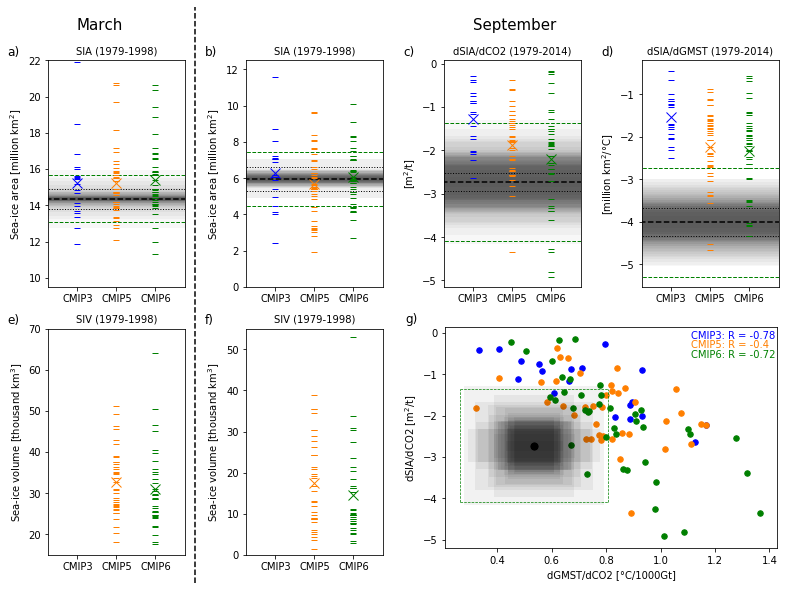

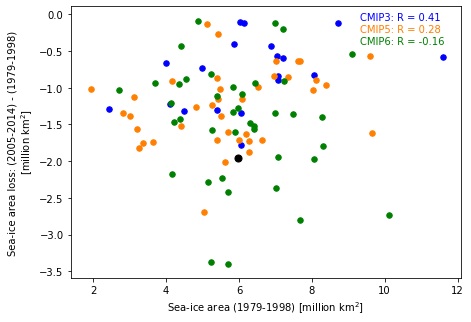

In [16]:
# This script plots Figure 2 and Figure 4 of the SIMIP paper draft. It reads the sensitivities from 
# npy files the sensitivities are calculated by the scripts sensitivity_cmip3.py, sensitivity_cmip5_6.py
# and sensitivity_obs.py
# Author: Jakob Doerr (jakob.doerr@mpimet.mpg.de)
# Date: 25.09.2019

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline
data = {} # data array for all the sensitivities
cmips = ['CMIP3','CMIP5','CMIP6']
hemisphere = 'nh'
for cmip in cmips:
    data[cmip] = np.load(cmip+'_sensitivity_'+hemisphere+'.npy',allow_pickle=True)
# observed sensitivities
obsdata = np.load('obs_sensitivity_'+hemisphere+'.npy',allow_pickle=True)
# the metrics in figure 2
metrics = ['sia_mean_mar_start','sia_mean_sept_start','sia_co2','sia_gmst','siv_mean_mar_start','siv_mean_sept_start']
ylabels = {'sia_co2':'dSIA/dCO2 [m$^2$/t]','sia_gmst':'dSIA/dGMST [million km$^2$/°C]','gmst_co2':'dGMST/dCO2 [°C/1000Gt]',
          'sia_mean_mar':'SIA March (1979-2014) [million km$^2$]', 'sia_mean_sept':'SIA Sept. (1979-2014) [million km$^2$]',
          'siv_mean_mar':'SIV March (1979-2014) [10$^3$ km$^3$]','siv_mean_sept':'SIV Sept. (1979-2014) [10$^3$ km$^3$]',
          'siv_mean_mar_start':'SIV March (1979-1998) [10$^3$ km$^3$]','siv_mean_sept_start':'SIV Sept. (1979-1998) [10$^3$ km$^3$]',
          'piCtrl_var':'Sept. SIA variability [million km$^2$]','ECS':'Equilibrium climate sensitivity [°C]',
          'sia_mean_mar_start':'SIA March (1979-1998) [million km$^2$]','sia_mean_sept_start':'SIA September (1979-1998) [million km$^2$]',
          'sia_mean_mar_end':'SIA March (2005-2014) [million km$^2$]','sia_mean_sept_end':'SIA September (2005-2014) [million km$^2$]',
          'sia_mean_sept_start_vari':'Var. of Sept. SIA (1979-1998)','sia_annual_cycle':'Annual cycle of SIA (2005-2014) [million km$^2$]'}
titles = {'sia_co2':'dSIA/dCO2 (1979-2014)','sia_gmst':'dSIA/dGMST (1979-2014)','gmst_co2':'dGMST/dCO2 (1979-2014)',
          'sia_mean_mar':'SIA (1979-2014)', 'sia_mean_sept':'SIA (1979-2014)',
          'siv_mean_mar':'SIV (1979-2014)','siv_mean_sept':'SIV (1979-2014)',
          'siv_mean_mar_start':'SIV (1979-1998)','siv_mean_sept_start':'SIV (1979-1998)',
          'piCtrl_var':'Sept. SIA variability [million km$^2$]','ECS':'Equilibrium climate sensitivity [°C]',
          'sia_mean_mar_start':'SIA (1979-1998)','sia_mean_sept_start':'SIA (1979-1998)',
          'sia_mean_mar_end':'SIA (2005-2014)','sia_mean_sept_end':'SIA (2005-2014)',
          'sia_mean_sept_start_vari':'Var. of Sept. SIA (1979-1998)','sia_annual_cycle':'Annual cycle of SIA (2005-2014)'}
units = {'sia_co2':'[m$^2$/t]','sia_gmst':'[million km$^2$/°C]','gmst_co2':'[°C/1000Gt]',
          'sia_mean_mar':'Sea-ice area [million km$^2$]', 'sia_mean_sept':'Sea-ice area [million km$^2$]',
          'siv_mean_mar':'Sea-ice volume [thousand km$^3$]','siv_mean_sept':'Sea-ice volume [thousand km$^3$]',
          'siv_mean_mar_start':'Sea-ice volume [thousand km$^3$]','siv_mean_sept_start':'Sea-ice volume [thousand km$^3$]',
          'piCtrl_var':'[million km$^2$]','ECS':'[°C]',
          'sia_mean_mar_start':'Sea-ice area [million km$^2$]','sia_mean_sept_start':'Sea-ice area [million km$^2$]',
          'sia_mean_mar_end':'Sea-ice area [million km$^2$]','sia_mean_sept_end':'Sea-ice area [million km$^2$]',
          'sia_mean_sept_start_vari':'Var. of Sept. SIA (1979-1998)','sia_annual_cycle':'Annual cycle of SIA (2005-2014) [million km$^2$]'}

letters = ['a)','b)','c)','d)','e)','f)','g)','h)']
colors = {'CMIP5':'#ff7f00','CMIP6':'green','CMIP3':'blue'}
# ---------------------------------------------------------------------------------------------------------
# Figure 1 (comparison of metric for CMIP3, 5, 6)
# ---------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(11,8))
i = 1
for metric in metrics: # loop over metrics, a subplot for each metric
    plt.subplot(2,4,i)
    #plot observed metrics, where available
    if metric in ['sia_co2','sia_gmst','gmst_co2','sia_mean_mar_start','sia_mean_sept_start']:
        obs_mean = np.nanmean(obsdata[metric])
        obs_std = st_dev(obsdata[metric])
        plt.hlines(obs_mean,0,4,linestyle='--',color='k')
        plt.hlines(obs_mean+obs_std,0,4,linestyle='dotted',color='k',linewidth=1)
        plt.hlines(obs_mean-obs_std,0,4,linestyle='dotted',color='k',linewidth=1)
        
        vari_mean = np.nanmean(data['CMIP6'][metric+'_vari'])
        plt.hlines(obs_mean+2*np.sqrt(vari_mean**2 + obs_std**2),0,4,linestyle='--',color='green',linewidth=1)
        plt.hlines(obs_mean-2*np.sqrt(vari_mean**2 + obs_std**2),0,4,linestyle='--',color='green',linewidth=1)
        # add shadings of the estimated internal variability for all CMIP6 single-model ensembles with 5 or more members
        for vari in data['CMIP6'][metric+'_vari']:
            plt.fill_between([0,4],[obs_mean-vari,obs_mean-vari],
                             [obs_mean+vari,obs_mean+vari],facecolor='k',alpha=0.03)
            
    # plot the model metrics
    for c,cmip in enumerate(cmips):
        temp = data[cmip][metric].copy()
        plt.plot(np.ones(len(data[cmip][metric]))*(c+1),temp,color=colors[cmip],linestyle='none',marker='_')
        # call out the high sensitivity models
        #if cmip == 'CMIP6':
        #    plt.plot(np.ones(len(data[cmip][metric][data[cmip]['ECS']>=4.5]))*(c+1.14),temp[data[cmip]['ECS']>=4.5],
        #             color='k',linestyle='none',marker='$<$',fillstyle='none',markeredgewidth=0.5,markersize=5)
        # plot ensemble mean
        plt.plot(c+1,np.nanmean(temp),color=colors[cmip],marker='x',markersize=10,linestyle='none')
    plt.xticks([1,2,3],['CMIP3','CMIP5','CMIP6'])
    plt.xlim(0.25,3.75)
    plt.text(-0.3,1.02,letters[i-1],fontsize=12,transform=plt.gca().transAxes)
    plt.ylabel(units[metric])
    plt.title(titles[metric],fontsize=10,loc='center')
    i+=1
    
    if metric == 'sia_mean_mar_start':
        plt.ylim(9.5,22)
    elif metric == 'sia_mean_sept_start':
        plt.ylim(0,12.5)
    if metric == 'siv_mean_mar_start':
        plt.ylim(15,70)
    elif metric == 'siv_mean_sept_start':
        plt.ylim(0,55)
print(data['CMIP6']['sia_gmst_allmember']['EC-Earth3-Veg'])

###!!!!!!!!!!!!!!
#data['CMIP5']['sia_co2'][-3] = np.nan
###!!!!!!!!!!!!!!!!!!!
# last panel: define function
def plot_fig4(metric1,metric2,letter,cmips = ['CMIP3','CMIP5','CMIP6']):
    plt.text(-0.12,1.02,letter,fontsize=12,transform=plt.gca().transAxes)
    i = 0
    for cmip in cmips:
        data1 = data[cmip][metric1]
        data2 = data[cmip][metric2]
        mask = np.logical_and(~np.isnan(data1), ~np.isnan(data2))

        f_data1 = data1[mask]
        f_data2 = data2[mask]
        plt.scatter(data1,data2,color=colors[cmip],s=30)
        if len(f_data1) > 0:
            corr = np.corrcoef(f_data1,f_data2)[1][0]
            plt.text(0.74,0.95-i*0.045,cmip+': R = '+str(np.round(corr,2)),color=colors[cmip],transform=plt.gca().transAxes)
            i += 1
    # plot observations and internal variability around it:
    if metric1 not in ['siv_mean_mar','siv_mean_mar_start','siv_mean_sept_start','piCtrl_var'] and metric2 not in ['siv_mean_mar_start','siv_mean_mar','siv_mean_sept','piCtrl_var']:
        plt.scatter(np.nanmean(obsdata[metric1]),np.nanmean(obsdata[metric2]),color='black',s=50)
        obs_std1 = st_dev(obsdata[metric1])
        obs_std2 = st_dev(obsdata[metric2])
        mean_x = np.nanmean(obsdata[metric1])
        mean_y = np.nanmean(obsdata[metric2])
        vari_x2 = 2*np.sqrt(np.nanmean(data['CMIP6'][metric1+'_vari'])**2+obs_std1**2)
        vari_y2 = 2*np.sqrt(np.nanmean(data['CMIP6'][metric2+'_vari'])**2+obs_std2**2)
        for i in range(len(data['CMIP6'][metric1+'_vari'])):
            vari_x = data['CMIP6'][metric1+'_vari'][i]
            vari_y = data['CMIP6'][metric2+'_vari'][i]
            plt.fill_between([mean_x-vari_x,mean_x+vari_x],[mean_y-vari_y,mean_y-vari_y],
                                     [mean_y+vari_y,mean_y+vari_y],facecolor='k',alpha=0.05)
        plt.plot([mean_x-vari_x2,mean_x+vari_x2],[mean_y-vari_y2,mean_y-vari_y2],linestyle='--',color='green',linewidth=0.7)
        plt.plot([mean_x-vari_x2,mean_x+vari_x2],[mean_y+vari_y2,mean_y+vari_y2],linestyle='--',color='green',linewidth=0.7)
        plt.plot([mean_x+vari_x2,mean_x+vari_x2],[mean_y-vari_y2,mean_y+vari_y2],linestyle='--',color='green',linewidth=0.7)
        plt.plot([mean_x-vari_x2,mean_x-vari_x2],[mean_y-vari_y2,mean_y+vari_y2],linestyle='--',color='green',linewidth=0.7)
    plt.xlabel(ylabels[metric1])
    plt.ylabel(ylabels[metric2])

#plt.subplot(2,2,4)
plt.axes([0.565, 0.06, 0.42, 0.384])
plot_fig4('gmst_co2','sia_co2','g)')

# add titles and vertical lines
l1 = lines.Line2D([0.25, 0.25], [0, 1], transform=fig.transFigure, figure=fig, linestyle='--',color='black')
fig.lines.extend([l1])
fig.text(0.1,0.96,'March',fontsize=15)
fig.text(0.6,0.96,'September',fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95],w_pad=2)
plt.savefig('./plots/SIMIP_fig1.pdf')


#### Plot mean area vs. SIA trends (CO2?)
for cmip in cmips:
    data[cmip]['SIA_trend'] = data[cmip]['sia_mean_sept_end'] - data[cmip]['sia_mean_sept_start']
obsdata['SIA_trend'] = obsdata['sia_mean_sept_end'] - obsdata['sia_mean_sept_start']
ylabels['SIA_trend'] = 'SIA (2005-2014) - (1979-1998)'

plt.figure(figsize=(7,5))
try:
    plot_fig4('sia_mean_sept_start','SIA_trend','')
except:
    pass
plt.ylabel('Sea-ice area loss: (2005-2014) - (1979-1998)\n [million km$^2$]')
plt.xlabel('Sea-ice area (1979-1998) [million km$^2$]')
plt.savefig('mean_SIA_diff_SIA.pdf')
#plt.tight_layout(rect=[0,0,1,1])

#### Fig. 2 (Evolution)

['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']
historical
ssp585
ssp245
ssp126


/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/home/mpim/m300681/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: Mean of empty slice


FileNotFoundError: [Errno 2] No such file or directory: './plots/SIMIP_fig3.pdf'

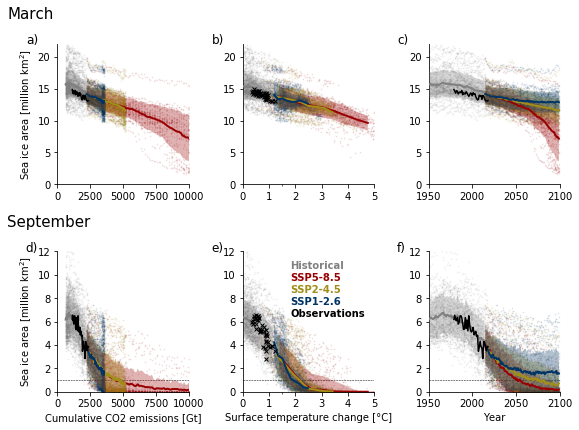

In [13]:
# This script plots Figure 1 of the SIMIP paper draft. It reads the model data from mat files,
# and the Observations (SIA, GMST) and the CO2 data from npy files.

# Author: Jakob Doerr (jakob.doerr@mpimet.mpg.de
# Date: 25.09.2019
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat,whosmat
from netCDF4 import Dataset,num2date
import matplotlib.patches as patches
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import interpolate

%matplotlib inline
cmip = 'CMIP6'
hemisphere = 'nh'

co2path = '/work/mh0033/m300681/IPCC/processed_data/emissions/'
cmippath = '/work/mh0033/m300681/IPCC/processed_data/'+cmip+'/'

if cmip == 'CMIP6':
    end_hist = 2014 # the final year of the historical scenario
    scenarios = ['historical','ssp585','ssp245','ssp126']#,'ssp119']
else:
    end_hist = 2005
    scenarios = ['historical','rcp26','rcp45','rcp85']

# create the time vectors
# model time
years = {'historical':np.arange(1950,end_hist+1),'ssp126':np.arange(2015,2100),'ssp119':np.arange(2015,2100),
         'ssp245':np.arange(2015,2100),'ssp585':np.arange(2015,2100), 'rcp26':np.arange(2006,2100),
        'rcp85':np.arange(2006,2100),'rcp45':np.arange(2006,2100)}
# observations time
obs_years = np.arange(1979,2019)

# colors for the scenarios (from https://pyam-iamc.readthedocs.io/en/latest/tutorials/ipcc_colors.html)
colors = {'historical':'grey','ssp245':'#a18e1a','ssp126':'#003466', 'ssp585':'#990002',
         'rcp85':'#990002','rcp45':'#5492CD','rcp26':(0,52/255,102/255),'ssp119':'#00AAD0'}
letters = ['a)','b)','c)','d)','e)','f)','g)','h)']
month_names = {3:'March',9:'September'}
ylims = {3:[0,22],9:[0,12]}
names = {'historical':'Historical','ssp119':'SSP1-1.9','ssp126':'SSP1-2.6','ssp245':'SSP2-4.5','ssp585':'SSP5-8.5'}
# ----------------------------------------------------------------------------------------------------
## Step 1: Read in the relevant data
# ---------------------------------------------------------------------------------------------------

# cmip6 data
# the data is stored in mat files, which contain data arrays with the dimensions (simulation, years, months)
# for SIA, SIV and GMST (no month dimension for GMST)
# the simulation dimension has an entry for every model member and the list of simulations is also stored in 
# the mat file, in the format 'MODEL-NAME_r*i1p1f*'

# determine the models which have SIA or GMST for any scenario. Later, once a model has no data, it will
# not be drawn in the figure (because of NaNs)
modellist = []
for scenario in scenarios:
    data = loadmat(cmip+'_'+scenario+'_'+hemisphere+'.mat')
    m_list = list(set([i[0:i.find('_')] for i in data['Simulation_names']]))
    modellist = np.concatenate([modellist,m_list])
modellist = list(sorted(set(modellist)))
print(modellist)

# create data arrays 
sia_cmip6 = {3:{},9:{}} # march and september for SIA and SIV
siv_cmip6 = {3:{},9:{}}
gmst_cmip6 = {} # yearly for GMST

# Start reading in the model data and pick the first member of every model
for scenario in scenarios:
    print(scenario)
    #Initialize data arrays:
    for month in [3,9]:
        sia_cmip6[month][scenario] = np.zeros((len(modellist),len(years[scenario])))
        siv_cmip6[month][scenario] = np.zeros((len(modellist),len(years[scenario])))
    gmst_cmip6[scenario] = np.zeros((len(modellist),len(years[scenario])))  
    
    # read in data
    raw_data = loadmat(cmip+'_'+scenario+'_'+hemisphere+'.mat')
    raw_years = raw_data['Years'][0]
    simulations = raw_data['Simulation_names']
    
    # create an index array which maps the years of the scenario in this script to the years in 
    # the scenario in the .mat data.
    year_idx = np.where(np.isin(raw_years,years[scenario]))[0]
    # create an index array for the control period, to be able to compute GMST anomalies
    control_idx = np.where(np.isin(raw_years,np.arange(1850,1900)))[0] 
    
    # sort data to data arrays and select first member
    for i,model in enumerate(modellist):
        index = np.asarray([j for j in range(len(simulations)) if model+'_' in simulations[j]])
        if len(index) > 0: # if there is data for this model in the mat file
            # sia, siv
            for month in [3,9]:
                # sia
                curr_data = raw_data['sia_'+hemisphere][index,:,month-1]
                sia_cmip6[month][scenario][i,:] = curr_data[0,year_idx]
                #sia_cmip6[month][scenario][i,:] = np.nanmean(curr_data[:,year_idx],0)
                # siv
                curr_data = raw_data['siv_'+hemisphere][index,:,month-1]
                siv_cmip6[month][scenario][i,:] = curr_data[0,year_idx]
                
                #siv_cmip6[month][scenario][i,:] = np.nanmean(curr_data[:,year_idx],0)
            # gmst (calculate anomalies) 
            curr_data = raw_data['gmst'][index,:]
            gmst_cmip6[scenario][i,:] = curr_data[0,year_idx] - np.nanmean(curr_data[0,control_idx])
            #gmst_cmip6[scenario][i,:] = np.nanmean(curr_data[:,year_idx] - np.nanmean(curr_data[:,control_idx]),0)
        else: # if there is no data, fill with NaNs
            for month in [3,9]:
                sia_cmip6[month][scenario][i,:] *= np.nan
                siv_cmip6[month][scenario][i,:] *= np.nan
            gmst_cmip6[scenario][i,:] *= np.nan
# ---------------------
# observations of SIA, take mean over several
# the observations are saved in npy files
obs_names = ['osisaf','nsidc_nt','nsidc_bt']
obspath = '/home/mpim/m300681/SIA_paper/data/'
obs_sia = {}
data = np.load(obspath+'SIA_observations_'+hemisphere+'.npy',allow_pickle=True)
obs_time = data['years']
for month in [3,9]:
    obs_data = np.nanmean([data[obs_name]["{:02d}".format(month)] for obs_name in obs_names],0)
    obs_sia[month] = np.zeros(len(obs_years))*np.nan
    # map the data to the correct years
    obs_sia[month][np.isin(obs_years,obs_time)] = obs_data[np.isin(obs_time,obs_years)]
    
# ---------------------
# observations of GMST 
obs_names = ['noaa','gistemp','HadCRUT','berkeley']
obs_gmst = np.zeros((len(obs_names),len(obs_years)))*np.nan
for i,obs_name in enumerate(obs_names):
    gmstfile = Dataset('/work/mh0033/m300681/IPCC/processed_data/obs/GMST_'+obs_name+'_yearly.nc')
    obs_data = np.squeeze(gmstfile.variables['tas_ano'][:].data.copy()) 
    time = np.squeeze(num2date(gmstfile.variables['time'][:].copy(),
                           gmstfile.variables["time"].units,
                           calendar = gmstfile.variables["time"].calendar))
    raw_years = np.asarray([time[i].year for i in range(len(time))])
    # the control period index array for the anomalies:
    control_idx = np.where(np.isin(raw_years,np.arange(1850,1900)))

    obs_data = obs_data - np.nanmean(obs_data[control_idx])
    obs_gmst[i,:] = np.zeros(len(obs_years))*np.nan
    # map the data to the correct years
    obs_gmst[i,np.isin(obs_years,raw_years)] = obs_data[np.isin(raw_years,obs_years)]
obs_gmst = np.nanmean(obs_gmst,0) 
# --------------------
# read in the cumulative co2 emissions for the simulations and for the observations
# they are also stored in npy files
# for the historical period until 2017, emissions are taken from the Carbon Budget 2018 
# (https://www.earth-syst-sci-data.net/10/2141/2018/)
# for the scenarios, CMIP6 co2 data is taken from the Input4MIP emissions data 
# (https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=welcome)
co2 = {}
data = np.load(co2path+'CO2_'+cmip+'.npy',allow_pickle=True)
#data = np.load(co2path+'CO2_conc_'+cmip+'.npy',allow_pickle=True)
for scenario in scenarios:   
    co2data = data[scenario][1,:]
    co2years = data[scenario][0,:]
    co2[scenario] = co2data[np.isin(co2years,years[scenario])]
    # for the co2 emissions in the period of observations, use emissions data for ssp245, 
    # because observed co2 emissions only go until 2017 (but sia and gmst observations until 2018)
    if scenario == 'ssp245':
        # co2 data for observations
        obs_co2 = co2data[np.isin(co2years,obs_years)]
        ## co2 for satellite historical period (1979-2014)
        hist_co2 = co2data[np.isin(co2years,np.arange(1979,2015))]

        
# end of data read in 
# ------------------------------------------------------------------------------------------
# plot 
fig = plt.figure(figsize=(8,6))

# draw SIA vs CO2 emissions
for m,month in enumerate([3,9]):
    plt.subplot(2,3,m*3+1)
    plt.text(-0.24,1.0,letters[m*3],fontsize=12,transform=plt.gca().transAxes)
    for scenario in scenarios:
        # sort the co2 values, b/c there can be a decrease in the cumulative co2 emissions
        # (for example in ssp126), which will look ugly in the plot
        x = co2[scenario]
        isort = np.argsort(x)
        x = x[isort]
        y_mean = np.nanmean(sia_cmip6[month][scenario],0)[isort]
        y_std = np.nanstd(sia_cmip6[month][scenario],0,ddof=1)[isort]
        
        for i,model in enumerate(modellist):
            plt.plot(co2[scenario],sia_cmip6[month][scenario][i,:],color=colors[scenario],
                     marker='.',alpha=0.1,linestyle='',markersize=1.414)
        # multi-model mean
        plt.plot(x,y_mean,color=colors[scenario],linewidth=2,zorder=100)
        # shading around mean
        plt.fill_between(x,y_mean-y_std,y_mean+y_std,facecolor=colors[scenario],alpha=0.3,zorder=100)
    # observations
    plt.plot(obs_co2,obs_sia[month],color='k',linestyle='-',marker='',markersize=np.sqrt(5),zorder=101) 
    # add 1 million km² line for ice-free threshold
    if month == 9:
        plt.plot([0,10000],[1,1],linestyle='--',color='k',linewidth=0.5)
    plt.ylabel('Sea ice area [million km$^2$]')
    plt.ylim(ylims[month])
    plt.xlim(0,10000)
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
plt.xlabel('Cumulative CO2 emissions [Gt]') 

# draw SIA vs GMST for March and September
for m,month in enumerate([3,9]):
    ax = plt.subplot(2,3,m*3+2)
    ax.text(-0.24,1.0,letters[m*3+1],fontsize=12,transform=plt.gca().transAxes)
    for scenario in scenarios:
        for i,model in enumerate(modellist):
            ax.plot(gmst_cmip6[scenario][i,:],sia_cmip6[month][scenario][i,:],
                    color=colors[scenario],marker='.',alpha=0.1,linestyle='',markersize=1.414)
            
        # try to draw a 'model mean' and a shading around the data, which is difficult,
        # since both GMST and SIA are varying between models
        # to do so, bin the data in GMST bins and compute mean and STD for every GMST bin (does not work too well, though, see figures)
        if scenario == 'historical':
            bins = np.linspace(np.nanpercentile(gmst_cmip6[scenario],5),min(np.nanpercentile(gmst_cmip6[scenario][:,-5::],99),5),10)
        else:
            bins = np.linspace(np.nanpercentile(gmst_cmip6[scenario],5),min(np.nanpercentile(gmst_cmip6[scenario][:,-5::],90),5),10)
        binned_index = np.digitize(gmst_cmip6[scenario],bins)
        binned_gmst_mean = np.asarray([np.nanmedian(gmst_cmip6[scenario][binned_index == i]) 
                                       for i in range(1, len(bins)) if len(binned_index[binned_index == i])> 50])
        binned_sia_mean = np.asarray([np.nanmedian(sia_cmip6[month][scenario][binned_index == i]) 
                                      for i in range(1, len(bins)) if len(binned_index[binned_index == i])> 50])
        binned_sia_std = [np.nanstd(sia_cmip6[month][scenario][binned_index == i],ddof=1) 
                          for i in range(1, len(bins)) if len(binned_index[binned_index == i])> 50]
        # bin mean
        ax.plot(binned_gmst_mean,binned_sia_mean,color=colors[scenario],linewidth=2,label=names[scenario],zorder=100)
        lower_bound = np.max([binned_sia_mean*0,binned_sia_mean-binned_sia_std],0)
        upper_bound = binned_sia_mean+binned_sia_std
        # bin shading
        ax.fill_between(binned_gmst_mean,lower_bound,upper_bound,facecolor=colors[scenario],alpha=0.3,zorder=100)
     
        #X = gmst_cmip6[scenario].flatten()
        #Y = sia_cmip6[month][scenario].flatten()
        ##ys = lowess(Y,X)
        ##plt.plot(ys[:,0],ys[:,1],linewidth=2,color=colors[scenario],label=names[scenario])
        #mask = np.where(np.logical_and(~np.isnan(X),~np.isnan(Y)))
        #X = X[mask]
        #Y = Y[mask]
        #confidence_ellipse(X,Y,ax,facecolor=colors[scenario])
    # finally, add observations to the plot
    ax.plot(obs_gmst,obs_sia[month],color='k',linestyle='',marker='x',markersize=np.sqrt(10),label='Observations',zorder=101)   
    # add 1 million km² line for ice-free threshold
    if month == 9:
        plt.plot([0,10],[1,1],linestyle='--',color='k',linewidth=0.5)
    #ax.set_ylabel('Sea ice area [million km$^2$]')
    ax.set_xlim(0,5)
    ax.set_ylim(ylims[month])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels(['0','1','2','3','4','5'])
    ax.set_xticks( [1,1.5,3,5], minor=True )
ax.set_xlabel('Surface temperature change [°C]')
lgd = plt.legend(frameon=False,labelspacing=0.2,markerscale=0,loc='upper right')
for item in lgd.legendHandles:
    item.set_visible(False)
# set colors of legend
for i,text in enumerate(lgd.get_texts()):
    plt.setp(text, color = lgd.legendHandles[i].get_c(),weight='bold')    

# draw SIA vs time
for m,month in enumerate([3,9]):
    ax = plt.subplot(2,3,m*3+3)
    ax.text(-0.24,1.0,letters[m*3+2],fontsize=12,transform=plt.gca().transAxes)
    #ax_lines = plt.subplot(2,20,14+m)
    for j,scenario in enumerate(scenarios):
        for i,model in enumerate(modellist):
            ax.plot(years[scenario],sia_cmip6[month][scenario][i,:],color=colors[scenario],
                    marker='.',alpha=0.1,linestyle='',markersize=1.414)
        # multi-model mean
        ax.plot(years[scenario],np.nanmean(sia_cmip6[month][scenario],0),color=colors[scenario],linewidth=2,zorder=100)
        lower_bound = np.nanmean(sia_cmip6[month][scenario],0)-np.nanstd(sia_cmip6[month][scenario],0,ddof=1)
        upper_bound = np.nanmean(sia_cmip6[month][scenario],0)+np.nanstd(sia_cmip6[month][scenario],0,ddof=1)
        # shadig around mean
        ax.fill_between(years[scenario],lower_bound,upper_bound,facecolor=colors[scenario],alpha=0.3,zorder=100)
        
        # add vertical lines at the end for future scenarios
        if scenario != 'historical':
            rect = patches.Rectangle((2100+3*j,max(lower_bound[-1],0)),1,upper_bound[-1]-max(lower_bound[-1],0),
                                     edgecolor=colors[scenario],facecolor=colors[scenario],clip_on=False)
            #ax.add_patch(rect)
    # observations
    ax.plot(obs_years,obs_sia[month],color='k',linestyle='-',marker='',markersize=np.sqrt(5),zorder=101)
    # add 1 million km² line for ice-free threshold
    if month == 9:
        plt.plot([1950,2100],[1,1],linestyle='--',color='k',linewidth=0.5)
    #ax.set_ylabel('Sea ice area [million km$^2$]')
    ax.set_ylim(ylims[month])
    ax.set_xlim(1950,2100)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
ax.set_xlabel('Year')

fig.text(0,0.96,'March',transform=fig.transFigure,fontsize=15)
fig.text(0,0.48,'September',transform=fig.transFigure,fontsize=15)
plt.tight_layout(h_pad = 4,w_pad = 0.5,rect=[0, 0, 1, 0.95])
plt.savefig('./plots/SIMIP_fig3.pdf')

# end of script

#### Fig. 3 (Ice free)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

%matplotlib inline

colors = {'historical':'grey','ssp245':'#a18e1a','ssp126':'#003466', 'ssp585':'#990002',
         'rcp85':'#990002','rcp45':'#5492CD','rcp26':(0,52/255,102/255),'ssp119':'#00AAD0'}
data = {} # data array for all the sensitivities
names = {'historical':'Historical','ssp119':'SSP1-1.9','ssp126':'SSP1-2.6','ssp245':'SSP2-4.5','ssp585':'SSP5-8.5'}
ylabels = {'time':'Year','co2':'Future cumulative \nCO2 emissions [Gt]','temp':'Surface temperature\n anomaly [°C]'}
ticks = {'co2':[0,1000,2000,3000,4000,5000,6000,7000,8000],'time':[2020,2030,2040,2050,2060,2070,2080,2090,2100],
        'temp':[1.5,2,2.5,3,3.5]}
minorticks = {'co2':[1000,3000,5000,7000,8000],'time':[2010,2030,2050,2070,2090],
        'temp':[1.5,2,2.5,3,3.5]}
ylim = {'time':2100,'co2':8000,'temp':3.5}
letters = ['a)','b)','c)']
hemisphere = 'nh'
plt.figure(figsize=(9,3))
for o,ordinate in enumerate(['co2','temp','time']):
    plt.subplot(1,3,o+1)
    data[ordinate] = {}
    for m,mode in enumerate(['all','select']):
        temp = np.load('CMIP6_ice_free_'+mode+'_'+ordinate+'.npy',allow_pickle=True)
        for s,scenario in enumerate(['ssp119','ssp126','ssp245','ssp585']):
            temp_data = np.asarray(temp[scenario])
            gets_icefree = np.asarray(np.load('CMIP6_ice_free_'+mode+'_time.npy',allow_pickle=True)[scenario])
            n_stillice = len(gets_icefree[np.logical_and(gets_icefree>2100,~np.isnan(temp_data))])
            n_members = len(gets_icefree[~np.isnan(gets_icefree)])
            if ordinate == 'co2':
                temp_data = temp_data - 2400
                print(mode)
                print(len(temp_data[temp_data<1000]))
            temp_data = temp_data[gets_icefree<2101]
            if mode == 'all':
                plt.plot(np.ones(len(temp_data))*(m+1)+0.2*s-0.3,temp_data,
                     color=colors[scenario],linestyle='none',marker='o',alpha=0.4,markersize=2,label=names[scenario])
            else:
                plt.plot(np.ones(len(temp_data))*(m+1)+0.2*s-0.3,temp_data,
                     color=colors[scenario],linestyle='none',marker='o',alpha=0.4,markersize=2)
            plt.text((m)*0.5+0.1*s+0.09,1.06,str(n_stillice),fontsize=8,transform=plt.gca().transAxes,horizontalalignment='center')
            plt.text((m)*0.5+0.1*s+0.09,1.01,str(n_members),fontsize=8,transform=plt.gca().transAxes,horizontalalignment='center')
    plt.xticks([1,2,3,4],['All\nmodels','Selected\nmodels']) 
    plt.xlim(0.5,2.5)
    plt.ylim(top=ylim[ordinate])
    plt.ylabel(ylabels[ordinate])
    plt.text(-0.25,1.07,letters[o],transform = plt.gca().transAxes)
    #plt.yticks(ticks[ordinate])
    plt.gca().set_yticks( minorticks[ordinate], minor=True )
    if ordinate == 'co2':
        lgd = plt.legend(frameon=False,labelspacing=0.2,markerscale=0,fontsize=8,loc='upper left',bbox_to_anchor=[-0.15,0,1,1])
        for item in lgd.legendHandles:
            item.set_visible(False)
        # set colors of legend
        for i,text in enumerate(lgd.get_texts()):
            plt.setp(text, color = lgd.legendHandles[i].get_c(),weight='bold')  
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('./plots/New_fig4.pdf')

#### SI: Plot 20-yr mean of GMST observations

In [ ]:
from netCDF4 import Dataset, num2date

# observations of GMST 
obs_years = np.arange(1850,2019)
obs_names = ['noaa','gistemp','HadCRUT','berkeley']
obs_gmst = np.zeros((len(obs_names),len(obs_years)))*np.nan
for i,obs_name in enumerate(obs_names):
    gmstfile = Dataset('/work/mh0033/m300681/IPCC/processed_data/obs/GMST_'+obs_name+'_yearly.nc')
    obs_data = np.squeeze(gmstfile.variables['tas_ano'][:].data.copy()) 
    time = np.squeeze(num2date(gmstfile.variables['time'][:].copy(),
                           gmstfile.variables["time"].units,
                           calendar = gmstfile.variables["time"].calendar))
    raw_years = np.asarray([time[i].year for i in range(len(time))])
    print(raw_years[0])
    # the control period index array for the anomalies:
    control_idx = np.where(np.isin(raw_years,np.arange(1850,1900)))

    obs_data = obs_data - np.nanmean(obs_data[control_idx])
    obs_gmst[i,:] = np.zeros(len(obs_years))*np.nan
    # map the data to the correct years
    obs_gmst[i,np.isin(obs_years,raw_years)] = obs_data[np.isin(raw_years,obs_years)]
    
for i in range(4):
    plt.plot(obs_years[9:-10],np.convolve(obs_gmst[i,:], np.ones((20,))/20, mode='valid'),label=obs_names[i].upper())
plt.legend()
plt.xlabel('Years')
plt.ylabel('Temp. anomaly vs. 1850-1900 [°C]')
plt.savefig('gmst_obs_20yr_mean.pdf')
plt.figure()
for i in range(4):
    plt.plot(obs_years,obs_gmst[i,:],label=obs_names[i].upper())
plt.legend()
plt.xlabel('Years')
plt.ylabel('Temp. anomaly vs. 1850-1900 [°C]')
plt.savefig('gmst_obs.pdf')